In [3]:
setwd("~/cdai/SpliFi/analysis")

In [4]:
suppressMessages(library(tidyverse))
suppressMessages(library(data.table))

In [5]:
library(patchwork)
library(ggtext)

In [6]:
library(magrittr)


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [7]:
suppressMessages(library(bedtoolsr))
suppressMessages(library(GenomicRanges))

In [8]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=180)

In [9]:
suppressMessages(library(cowplot))
theme_set(theme_cowplot(font_size = 14))

In [10]:
genes <- fread('/project2/yangili1/cdai/annotations/hg38/gencode.v43.primary_assembly.annotation.csv.gz')
genes <- genes[feature == "gene" & gene_type == "protein_coding", .(seqname, start, end, gene_name, gene_id, strand)] %>% unique

In [11]:
genes <- makeGRangesFromDataFrame(genes, keep.extra.columns = T, ignore.strand = F)

In [12]:
length(genes)
head(genes)

[1] 20042

GRanges object with 6 ranges and 2 metadata columns:
      seqnames        ranges strand |   gene_name            gene_id
         <Rle>     <IRanges>  <Rle> | <character>        <character>
  [1]     chr1   65419-71585      + |       OR4F5  ENSG00000186092.7
  [2]     chr1 450740-451678      - |      OR4F29  ENSG00000284733.2
  [3]     chr1 685716-686654      - |      OR4F16  ENSG00000284662.2
  [4]     chr1 923923-944575      + |      SAMD11 ENSG00000187634.13
  [5]     chr1 944203-959309      - |       NOC2L ENSG00000188976.11
  [6]     chr1 960584-965719      + |      KLHL17 ENSG00000187961.15
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

# Introduction


Differential splicing analyses in GTEx

Contrasts: 

- Brain-Cerebellum v. Cells-EBV-transformedlymphocytes
- Brain-Cerebellum v. Kidney-Cortex
- Brain-Cerebellum v. Liver


Use annotated noise_by_intron files to get labeling of introns

In [13]:
comps <- c("Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes",
            "Brain-Cerebellum_v_Kidney-Cortex",
            "Brain-Cerebellum_v_Liver",
            "Liver_v_Kidney-Cortex",
            "Liver_v_Muscle-Skeletal",
            "Brain-Cortex_v_Brain-FrontalCortex_BA9_",
            "WholeBlood_v_Muscle-Skeletal"
)
pvals.f <- paste("../code/results/ds/GTEx/", comps, "/ds_cluster_significance.txt", sep="")
betas.f <- paste("../code/results/ds/GTEx/", comps, "/ds_effect_sizes.txt", sep="")
introns.f <- paste("../code/results/ds/GTEx/", comps, "/ds_perind.counts.noise_by_intron.gz", sep="")

names(pvals.f) <- comps
names(betas.f) <- comps
names(introns.f) <- comps

In [14]:
getIntronLabels <- function(f) {
    cmd <- paste0('zcat ', f, " | awk '{print $1}'", collapse = " ")
    introns <- fread(cmd = cmd)
    introns <- introns[, .(intron = str_sub(chrom, 1, -4), 
                           cluster = str_split(chrom, ":") %>% map_chr(~paste(.x[1], .x[4], sep=":")),
                           itype = str_sub(chrom, -2, -1)
                          )]
    introns[, ctype := paste(sort(unique(itype)), sep="", collapse=","), by = cluster]
    
    return(introns)
}

In [15]:
pvals <- map(pvals.f, fread)
betas <- map(betas.f, fread)
introns <- map(introns.f, getIntronLabels)

In [16]:
pvals[[1]][1:3]
betas[[1]][1:3]
introns[[1]][1:3]

status,loglr,df,p,cluster,p.adjust
<chr>,<dbl>,<int>,<dbl>,<chr>,<dbl>
<=1 junction in cluster,NA,NA,NA,chr1:clu_10_+,NA
<=1 junction in cluster,NA,NA,NA,chr1:clu_1000_+,NA
Success,571.9535,3,1.084591e-247,chr1:clu_1002_+,1.558616e-246


intron,logef,Brain-Cerebellum,Cells-EBV-transformedlymphocytes,deltapsi
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:75724817:75728388:clu_1002_+,0.7081498,0.003776209,0.006208044,0.002431835
chr1:75724817:75728400:clu_1002_+,0.3671185,0.376768275,0.440418013,0.063649738
chr1:75724817:75732643:clu_1002_+,-1.3719115,0.137389785,0.028215910,-0.109173875


intron,cluster,itype,ctype
<chr>,<chr>,<chr>,<chr>
chr1:779092:781936:clu_3_+,chr1:clu_3_+,IN,IN
chr1:779092:803918:clu_3_+,chr1:clu_3_+,IN,IN
chr1:804222:804775:clu_5_+,chr1:clu_5_+,IN,IN


In [17]:
if (all(names(pvals) == names(introns))) {
    print("do")
    pvals <- map2(
                pvals,
                introns,
                \(x,y) {
                    left_join(x, unique(y[, .(cluster, ctype)]), by = "cluster")
                }
            )
}

[1] "do"


In [18]:
if (all(names(betas) == names(introns))) {
    print("do")
    betas <- map2(
                betas,
                introns,
                \(x,y) {
                    left_join(x, unique(y[, .(intron, itype, ctype)]), by = "intron")
                }
            )
}

[1] "do"


In [19]:
names(introns)

[1] "Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes"
[2] "Brain-Cerebellum_v_Kidney-Cortex"                   
[3] "Brain-Cerebellum_v_Liver"                           
[4] "Liver_v_Kidney-Cortex"                              
[5] "Liver_v_Muscle-Skeletal"                            
[6] "Brain-Cortex_v_Brain-FrontalCortex_BA9_"            
[7] "WholeBlood_v_Muscle-Skeletal"

# Number of significant intron clusters

set FDR=0.1

In [20]:
FDR=.1

In [21]:
head(pvals[[1]])

status,loglr,df,p,cluster,p.adjust,ctype
<chr>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<chr>
<=1 junction in cluster,NA,NA,NA,chr1:clu_10_+,NA,PR
<=1 junction in cluster,NA,NA,NA,chr1:clu_1000_+,NA,PR
Success,571.9535,3,1.084591e-247,chr1:clu_1002_+,1.558616e-246,PR
Success,858.4211,5,0.000000e+00,chr1:clu_1003_+,0.000000e+00,PR
Success,389.6304,4,2.384755e-167,chr1:clu_1004_+,2.068752e-166,"PR,UP"
<=1 junction in cluster,NA,NA,NA,chr1:clu_1005_+,NA,PR


In [22]:
head(pvals[[1]])$df %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    3.0     3.5     4.0     4.0     4.5     5.0       3 

In [23]:
imap_dfr(
    pvals, 
    \(x, y) {
        x[, .(.N, comps = y), by = .(passFDR = `p.adjust` < FDR)]
    }
) %>% 
.[, .(comps, passFDR, N, P = N/sum(N)), by = comps]

comps,comps,passFDR,N,P
<chr>,<chr>,<lgl>,<int>,<dbl>
Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,NA,14233,0.3449254
Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,TRUE,22917,0.5553751
Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,FALSE,4114,0.0996995
Brain-Cerebellum_v_Kidney-Cortex,Brain-Cerebellum_v_Kidney-Cortex,NA,13816,0.3274477
Brain-Cerebellum_v_Kidney-Cortex,Brain-Cerebellum_v_Kidney-Cortex,TRUE,21589,0.5116726
Brain-Cerebellum_v_Kidney-Cortex,Brain-Cerebellum_v_Kidney-Cortex,FALSE,6788,0.1608798
Brain-Cerebellum_v_Liver,Brain-Cerebellum_v_Liver,NA,14638,0.3536518
Brain-Cerebellum_v_Liver,Brain-Cerebellum_v_Liver,TRUE,21718,0.5247034
Brain-Cerebellum_v_Liver,Brain-Cerebellum_v_Liver,FALSE,5035,0.1216448


In [24]:
imap_dfr(
    pvals, 
    \(x, y) {
        x[, .(.N, comps = y), by = .(ctype, passFDR = `p.adjust` < FDR)]
    }
) %>% 
.[, .(ctype, passFDR, N, P = scales::percent(N/sum(N), .1)), by = comps] %>% 
.[ctype %in% c("PR", "PR,UP") & passFDR == T] %>% 
.[order(comps, -N)]

comps,ctype,passFDR,N,P
<chr>,<chr>,<lgl>,<int>,<chr>
Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,PR,TRUE,12121,29.4%
Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,"PR,UP",TRUE,9457,22.9%
Brain-Cerebellum_v_Kidney-Cortex,PR,TRUE,11522,27.3%
Brain-Cerebellum_v_Kidney-Cortex,"PR,UP",TRUE,8696,20.6%
Brain-Cerebellum_v_Liver,PR,TRUE,11706,28.3%
Brain-Cerebellum_v_Liver,"PR,UP",TRUE,8767,21.2%
Brain-Cortex_v_Brain-FrontalCortex_BA9_,PR,TRUE,3288,8.0%
Brain-Cortex_v_Brain-FrontalCortex_BA9_,"PR,UP",TRUE,2838,6.9%
Liver_v_Kidney-Cortex,PR,TRUE,7907,19.3%


In [25]:
relabelLong <- function(x, len=20) {
    str_replace_all(x, "[-_]", " ") %>% 
    str_wrap(len)
}

In [26]:
relabelLong("Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes")

[1] "Brain Cerebellum\nv Cells EBV\ntransformedlymphocytes"

In [165]:
options(repr.plot.width = 9, repr.plot.height = 5, repr.plot.res = 180)

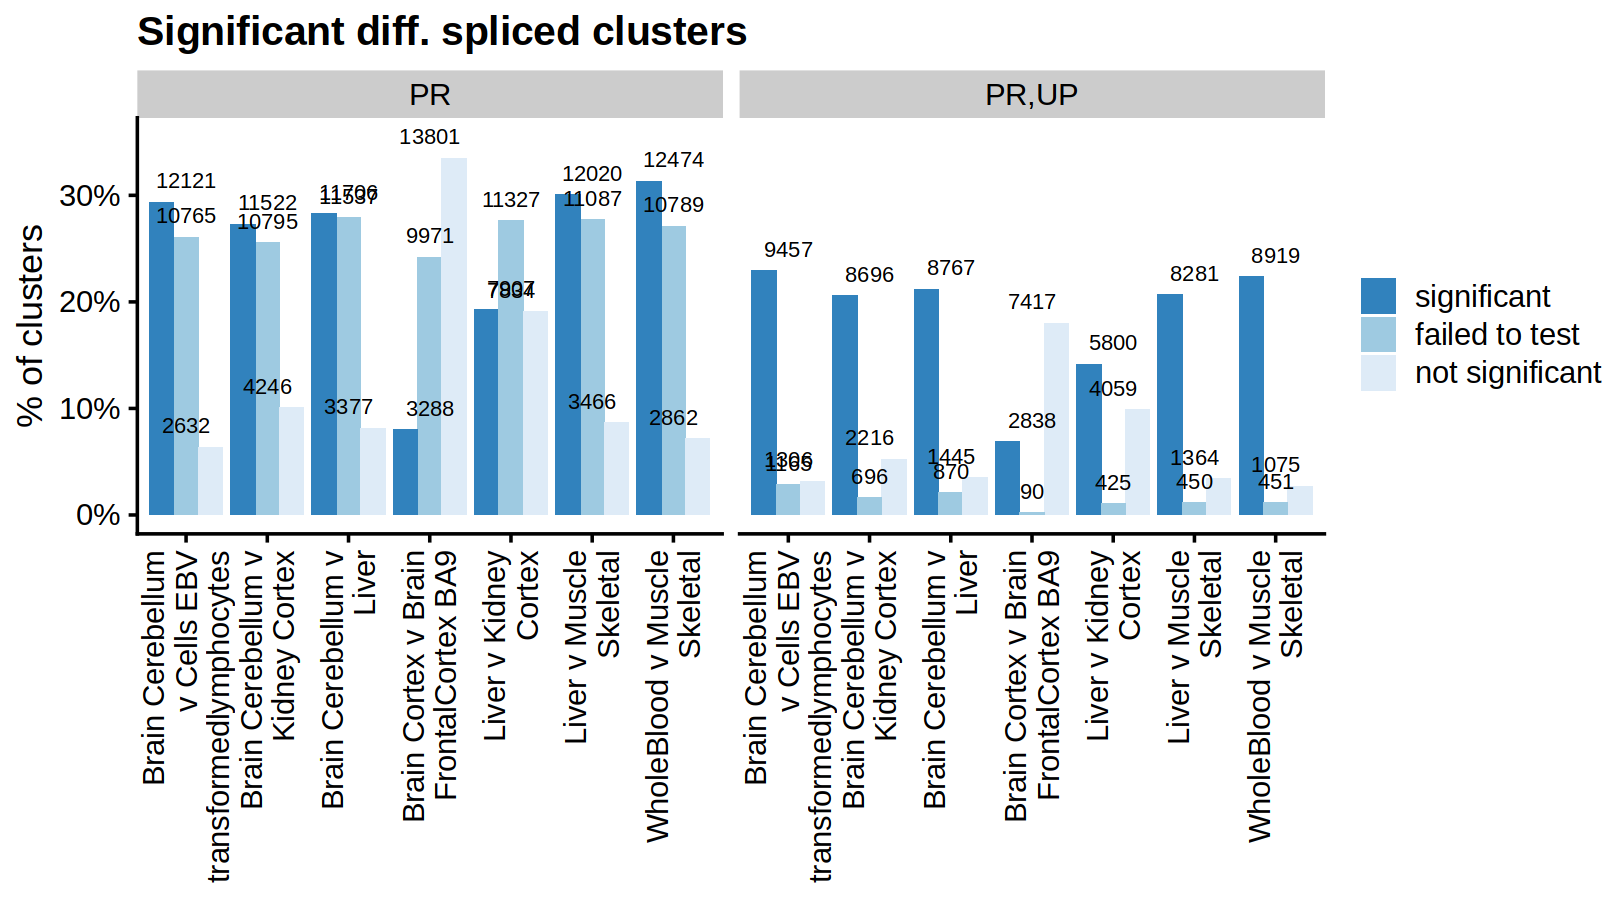

In [166]:
imap_dfr(
    pvals,
    \(x, y) {
        x[, .(.N, comps = y), by = .(ctype, passFDR = `p.adjust` < FDR)
        ][, .(N, ctype, comps, passFDR = as.integer(passFDR))
        ][, .(N, ctype, comps, passFDR = case_when(
            passFDR == 1 ~ "significant",
            passFDR == 0 ~ "not significant",
            TRUE ~ "failed to test"
        ))] %>% 
        .[, .(ctype, N, P = N/sum(N), passFDR), by = comps] %>% 
        .[ctype %in% c("PR", "PR,UP")]
    }
 ) %>%
    ggplot() + geom_col(aes(x = comps, y = P, fill = forcats::fct_reorder(passFDR, -N)), position = "dodge") +
        geom_text(aes(x = comps, y = P + .02, label = N, hjust = passFDR), size = 3) +
        scale_x_discrete(labels = relabelLong) +
        scale_y_continuous(labels = scales::percent) +
        scale_fill_brewer(name = NULL, palette = "Blues", direction = -1) +
        labs(x = NULL, y = "% of clusters", title = "Significant diff. spliced clusters") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
        facet_wrap(~ctype)


# Effect sizes

In [29]:
# significant cluster ids

sig.clusters <- map(
    pvals, 
    \(x, y) {
        x[`p.adjust` < FDR, cluster]
    }
)

In [30]:
betas <- map(betas, ~.x[, cluster := (str_split(intron, ":") %>% map_chr(~paste(.x[1], .x[4], sep=":")))])

Warning message in `[.data.table`(.x, , `:=`(cluster, (str_split(intron, ":") %>% :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”
Warning message in `[.data.table`(.x, , `:=`(cluster, (str_split(intron, ":") %>% :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- a

In [31]:
pvals[[1]][str_detect(cluster, "clu_1002_")]

status,loglr,df,p,cluster,p.adjust,ctype
<chr>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<chr>
Success,571.9535,3,1.084591e-247,chr1:clu_1002_+,1.558616e-246,PR


In [32]:
names(betas)
names(sig.clusters)

[1] "Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes"
[2] "Brain-Cerebellum_v_Kidney-Cortex"                   
[3] "Brain-Cerebellum_v_Liver"                           
[4] "Liver_v_Kidney-Cortex"                              
[5] "Liver_v_Muscle-Skeletal"                            
[6] "Brain-Cortex_v_Brain-FrontalCortex_BA9_"            
[7] "WholeBlood_v_Muscle-Skeletal"

[1] "Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes"
[2] "Brain-Cerebellum_v_Kidney-Cortex"                   
[3] "Brain-Cerebellum_v_Liver"                           
[4] "Liver_v_Kidney-Cortex"                              
[5] "Liver_v_Muscle-Skeletal"                            
[6] "Brain-Cortex_v_Brain-FrontalCortex_BA9_"            
[7] "WholeBlood_v_Muscle-Skeletal"

In [33]:
if (all(names(betas) == names(sig.clusters))) {
    betas.sig <- map2(betas, sig.clusters, ~.x[cluster %in% .y])
}

In [34]:
sig.clusters[[2]] %>% head

[1] "chr1:clu_1002_+" "chr1:clu_1003_+" "chr1:clu_1004_+" "chr1:clu_1006_+"
[5] "chr1:clu_1007_+" "chr1:clu_1011_+"

In [35]:
betas.sig[[2]] %>% head

intron,logef,Brain-Cerebellum,Kidney-Cortex,deltapsi,itype,ctype,cluster
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1:75724817:75728388:clu_1002_+,0.4201798,0.004365541,0.0054051575,0.001039616,PR,PR,chr1:clu_1002_+
chr1:75724817:75728400:clu_1002_+,0.3394861,0.378081032,0.4318275142,0.053746483,PR,PR,chr1:clu_1002_+
chr1:75724817:75732643:clu_1002_+,-1.0486389,0.134640866,0.0383749030,-0.096265963,PR,PR,chr1:clu_1002_+
chr1:75728488:75732643:clu_1002_+,0.2889731,0.482912561,0.5243924253,0.041479865,PR,PR,chr1:clu_1002_+
chr1:75732922:75733050:clu_1003_+,-1.3547423,0.014904773,0.0008993951,-0.014005378,PR,PR,chr1:clu_1003_+
chr1:75732922:75733527:clu_1003_+,1.6555048,0.413167514,0.5059236479,0.092756134,PR,PR,chr1:clu_1003_+


In [36]:
# map(pvals, dim) %>% print
map(sig.clusters, length) %>% print
map(betas.sig, dim) %>% print

$`Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes`
[1] 22917

$`Brain-Cerebellum_v_Kidney-Cortex`
[1] 21589

$`Brain-Cerebellum_v_Liver`
[1] 21718

$`Liver_v_Kidney-Cortex`
[1] 14595

$`Liver_v_Muscle-Skeletal`
[1] 21523

$`Brain-Cortex_v_Brain-FrontalCortex_BA9_`
[1] 6440

$`WholeBlood_v_Muscle-Skeletal`
[1] 22666

$`Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes`
[1] 83439     8

$`Brain-Cerebellum_v_Kidney-Cortex`
[1] 77828     8

$`Brain-Cerebellum_v_Liver`
[1] 76742     8

$`Liver_v_Kidney-Cortex`
[1] 54404     8

$`Liver_v_Muscle-Skeletal`
[1] 74646     8

$`Brain-Cortex_v_Brain-FrontalCortex_BA9_`
[1] 25704     8

$`WholeBlood_v_Muscle-Skeletal`
[1] 78165     8



In [37]:
betas.sig[[3]] %>% 
    .[, .(intron, deltapsi, rk = frank(-abs(deltapsi)))] %>% 
    .[rk < 50] %>% head

intron,deltapsi,rk
<chr>,<dbl>,<dbl>
chr1:113681336:113682896:clu_1258_+,0.9456466,30.0
chr1:10272306:10275427:clu_169_+,0.9365349,48.0
chr10:69895576:69897474:clu_23318_+,0.9462744,28.5
chr10:69895576:69898696:clu_23318_+,-0.9462744,28.5
chr10:112182891:112183692:clu_24573_-,-0.9750666,9.0
chr11:46659485:46665382:clu_25169_+,0.9556514,22.0


In [38]:
hist1 <- imap_dfr(betas.sig, ~.x[, .(intron, deltapsi, grp = .y)]) %>% 
    ggplot() + geom_histogram(aes(x = abs(deltapsi), fill = grp), binwidth = .01) +
    scale_fill_brewer(name=NULL, palette = "Accent", labels = relabelLong) + 
    theme_bw() +
    theme(legend.position = "right", panel.grid = element_blank()) 

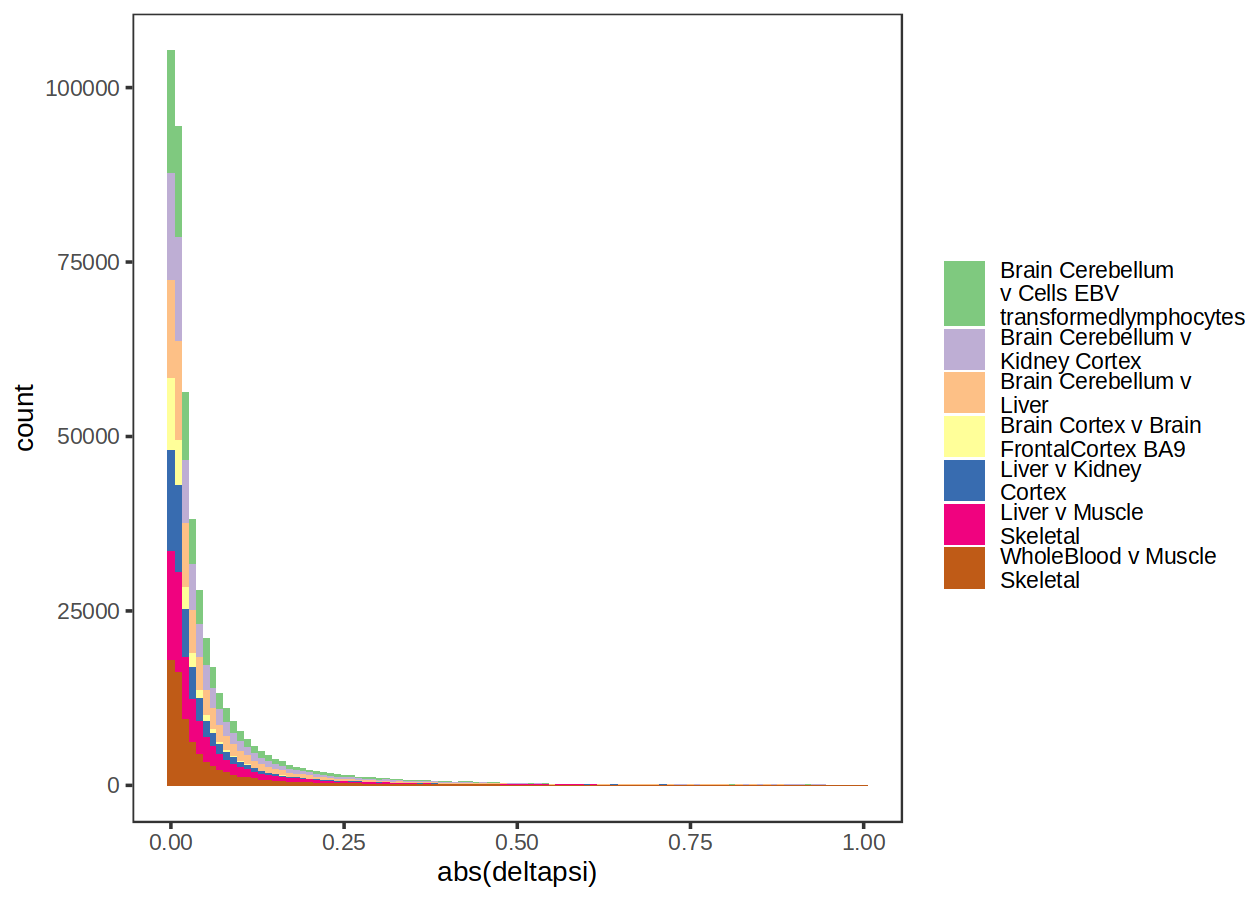

In [39]:
hist1

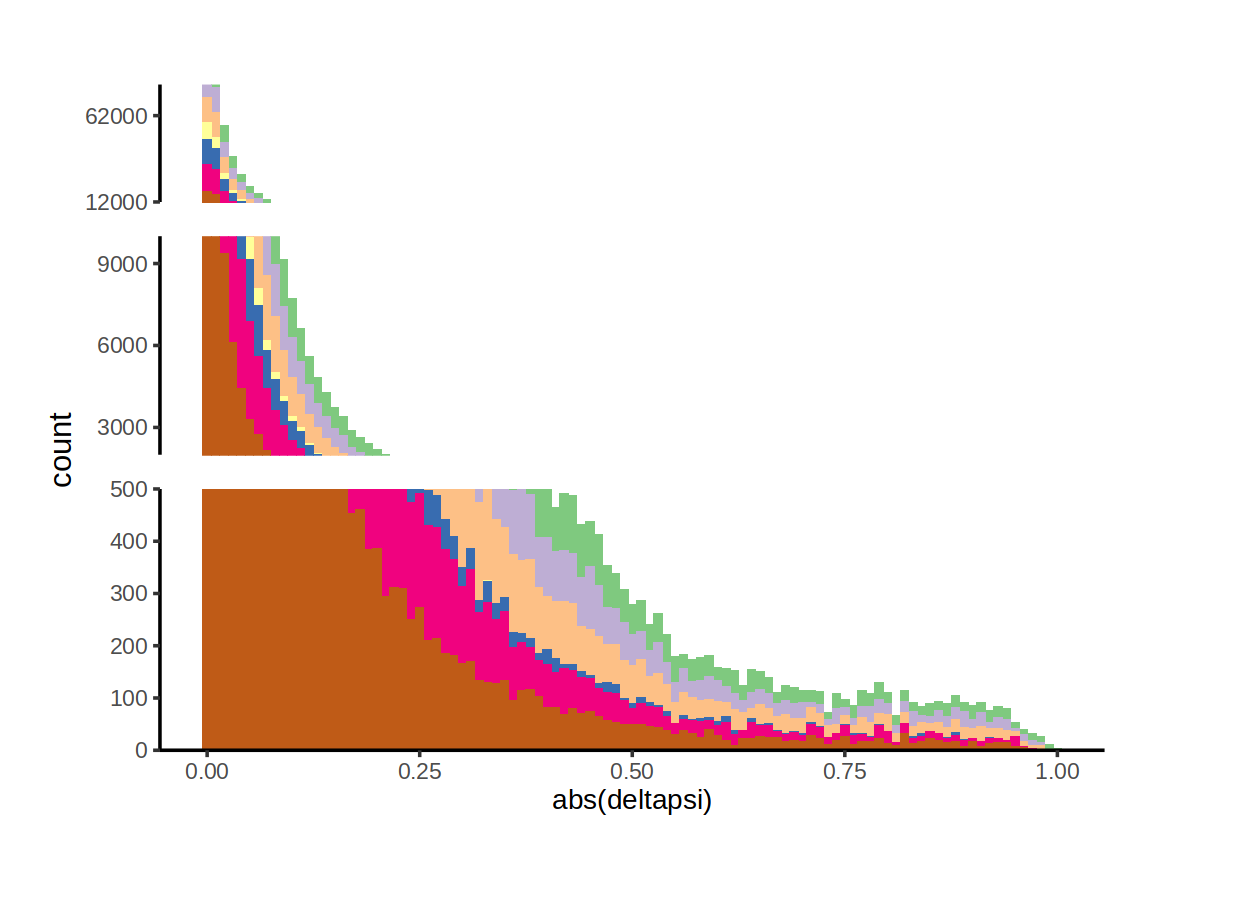

In [40]:
gg.gap::gg.gap(hist1, ylim = c(0, 8e4), 
               segments = list(c(500, 2000), c(1e4, 1.2e4)), 
               tick_width = c(100, 3e3, 5e4),
               rel_heights = c(.7, 0, .5, 0, .3)
              )

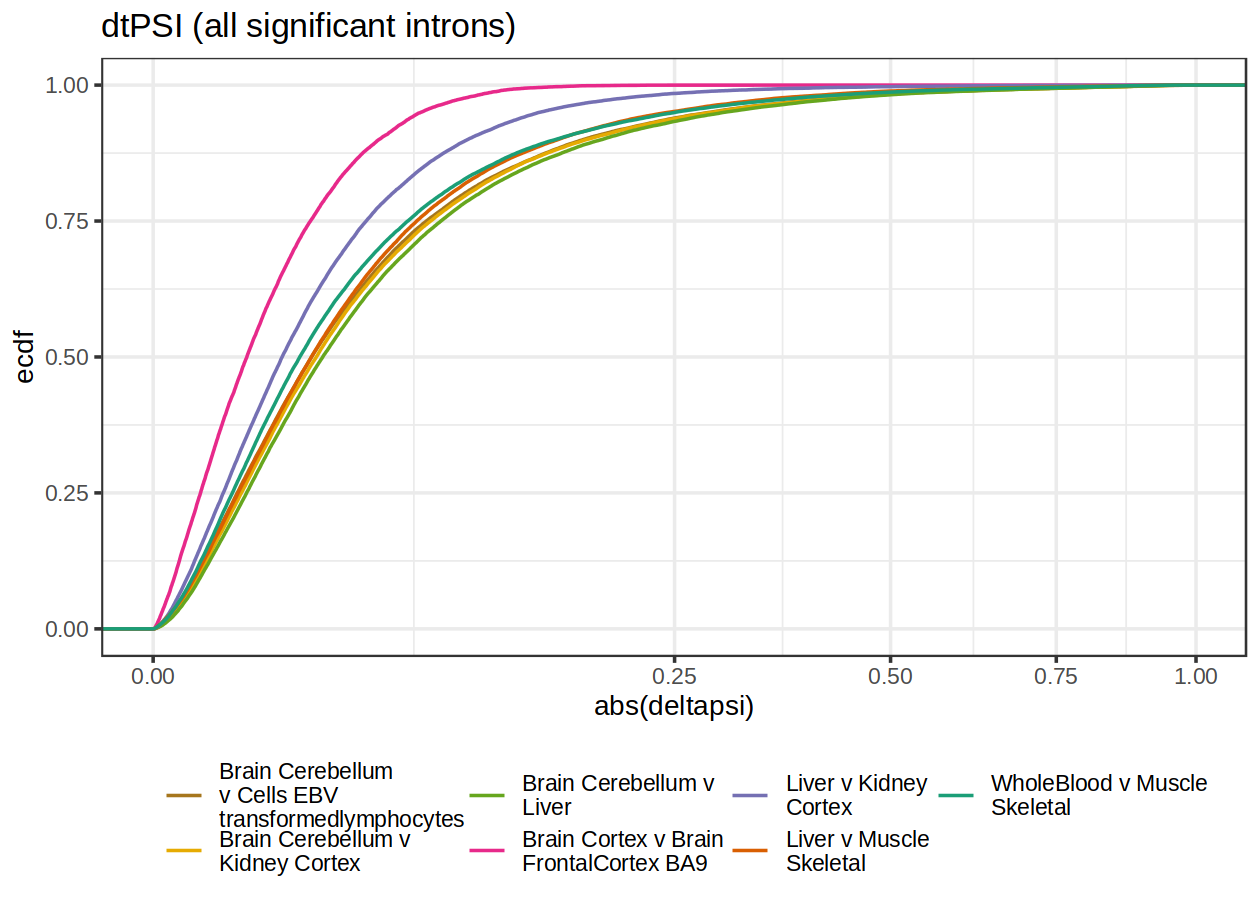

In [41]:
imap_dfr(betas.sig, ~.x[, .(intron, deltapsi, grp = .y)]) %>% 
    ggplot() + stat_ecdf(aes(x = abs(deltapsi), color = grp)) +
        scale_color_brewer(type = "qual", palette = 2, direction = -1, label = relabelLong, name = NULL) +
        labs(title = "dtPSI (all significant introns)") +
        scale_x_sqrt() +
        theme_bw() +
        theme(legend.position = "bottom")

In [42]:
betas.sig[[1]][1:3]

intron,logef,Brain-Cerebellum,Cells-EBV-transformedlymphocytes,deltapsi,itype,ctype,cluster
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1:75724817:75728388:clu_1002_+,0.7081498,0.003776209,0.006208044,0.002431835,PR,PR,chr1:clu_1002_+
chr1:75724817:75728400:clu_1002_+,0.3671185,0.376768275,0.440418013,0.063649738,PR,PR,chr1:clu_1002_+
chr1:75724817:75732643:clu_1002_+,-1.3719115,0.137389785,0.028215910,-0.109173875,PR,PR,chr1:clu_1002_+


In [43]:
hist2 <- imap_dfr(betas.sig, ~.x[ctype %in% c("PR", "PR,UP"), .(intron, deltapsi, itype, ctype, grp = .y)]) %>% 
    ggplot() + geom_histogram(aes(x = abs(deltapsi), fill = itype), binwidth = .01) +
    scale_fill_brewer(name=NULL, palette = "Accent", labels = relabelLong) + 
    theme_bw() +
    theme(legend.position = "bottom", panel.grid = element_blank()) +
    facet_wrap(~grp, nrow = 1)

In [44]:
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 180)

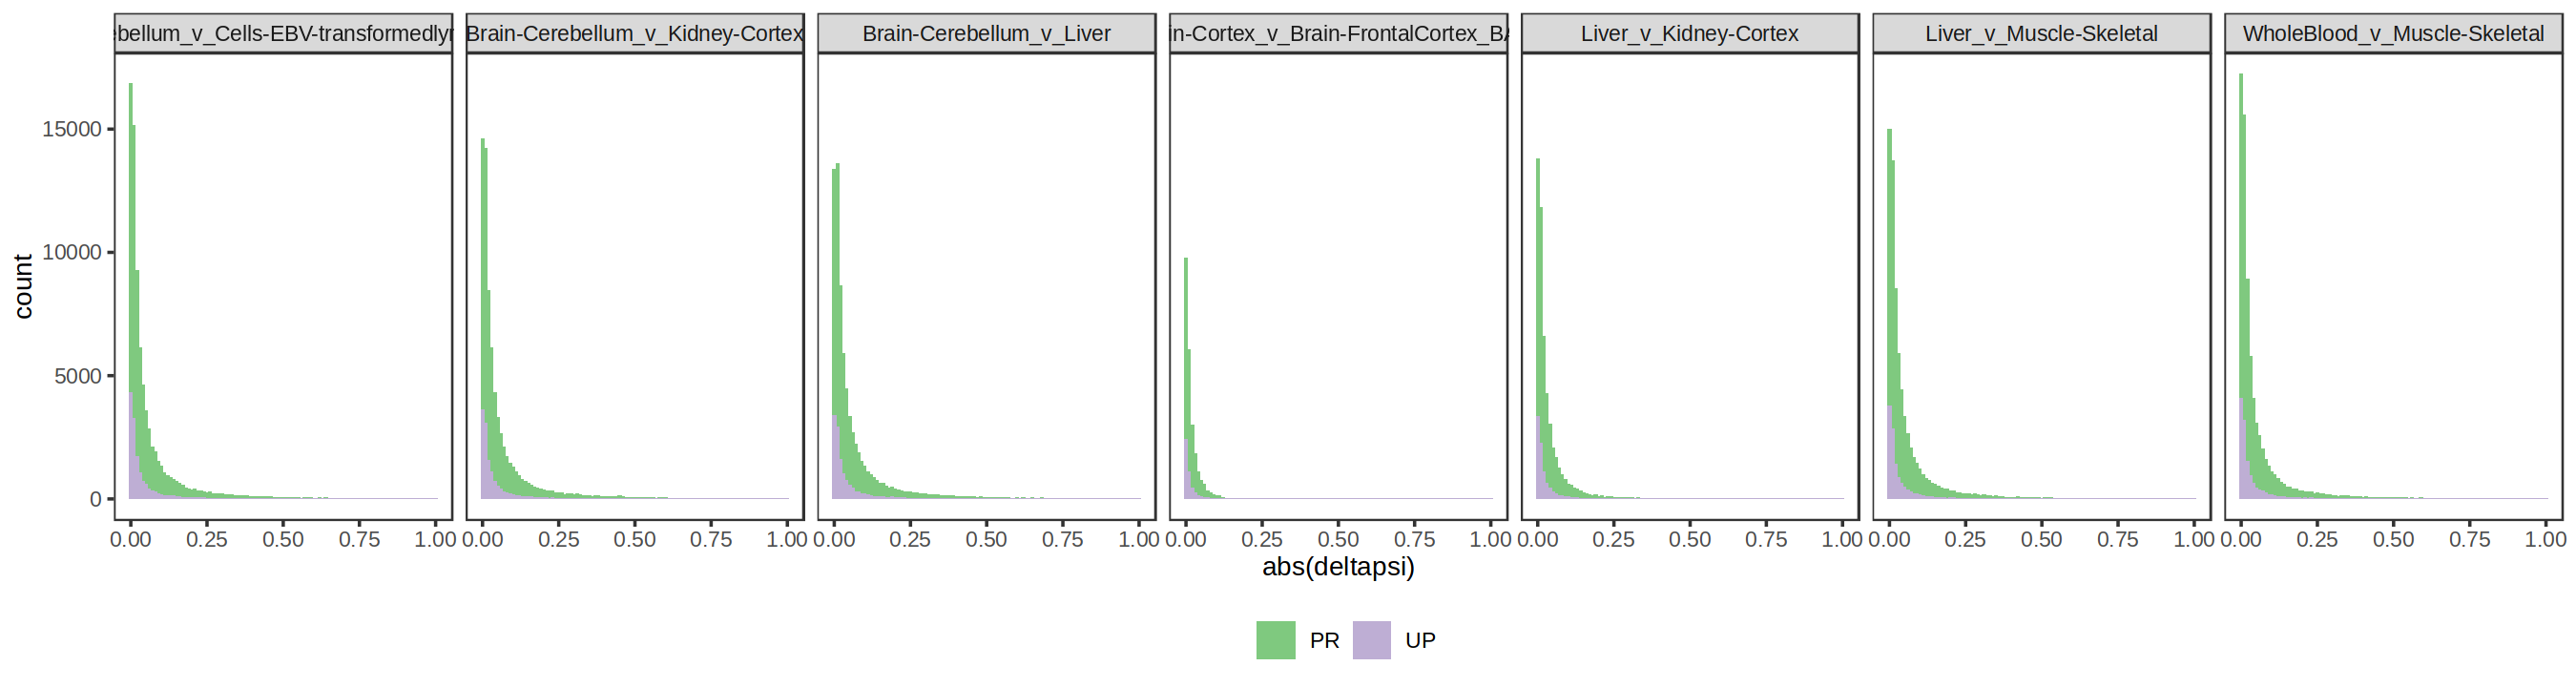

In [45]:
hist2

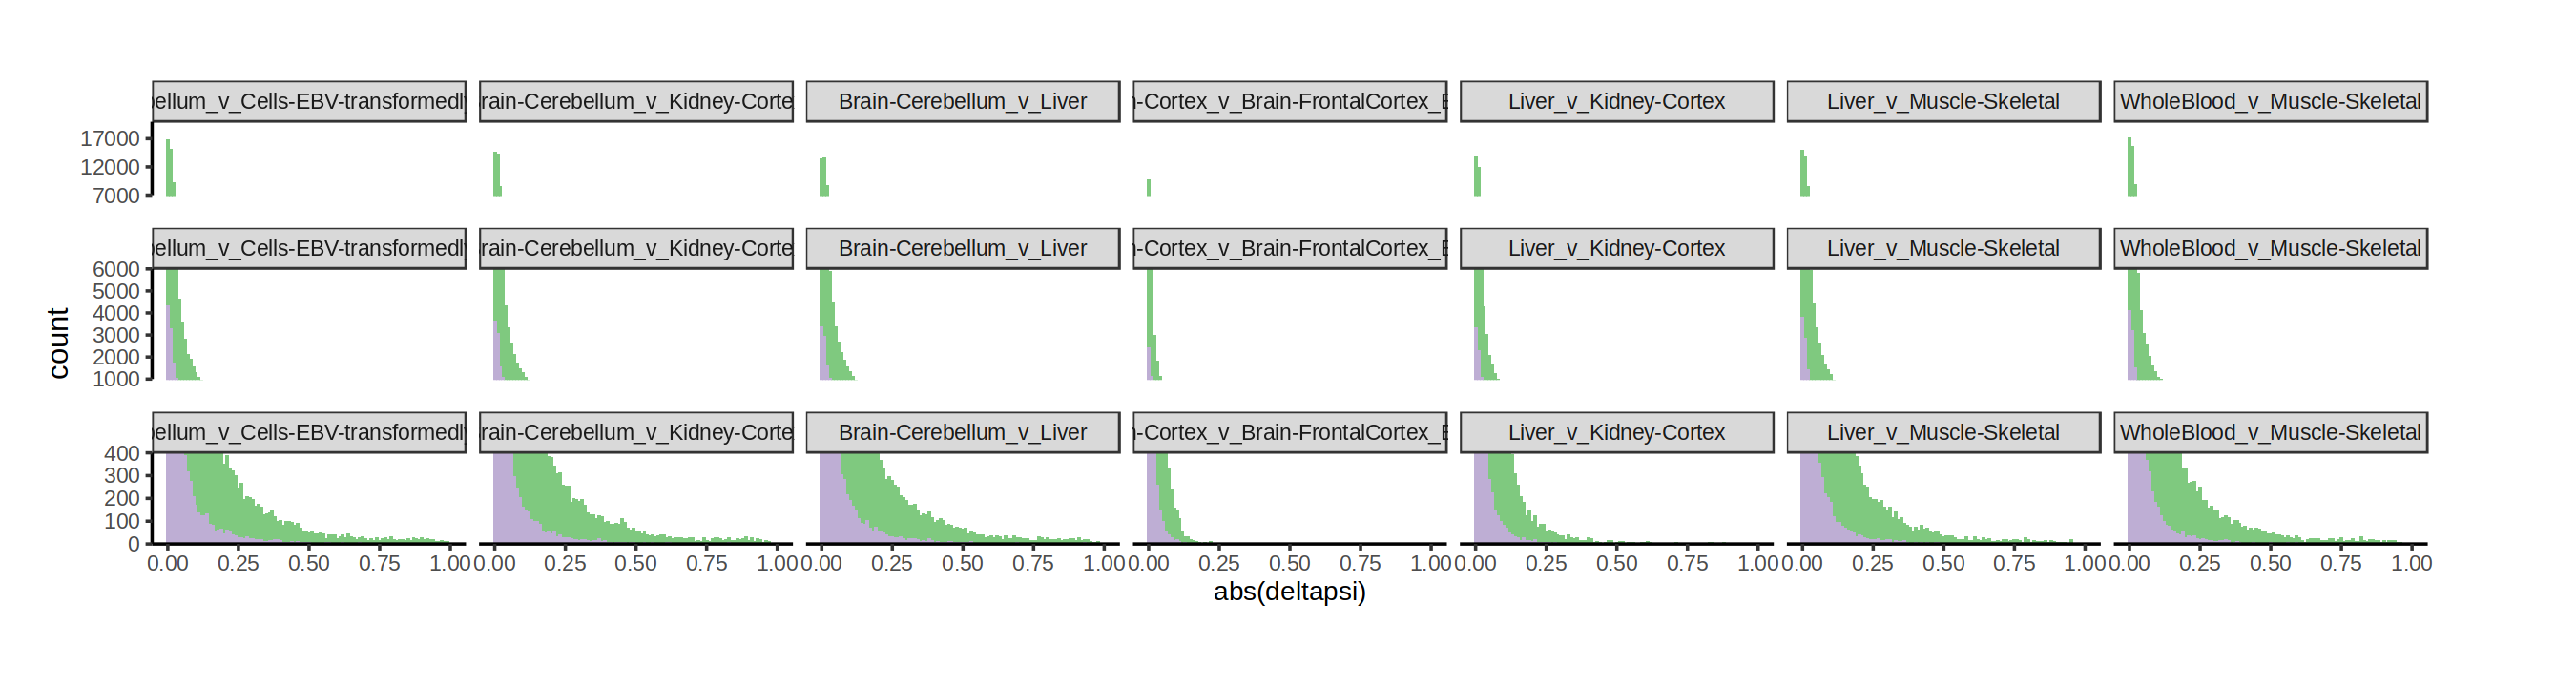

In [46]:
gg.gap::gg.gap(hist2, ylim = c(0, 2e4), 
               segments = list(c(400,1000), c(6000,7000)), 
               tick_width = c(100, 1e3, 5e3),
               rel_heights = c(.6, 0, .5, 0, .4)
              )

In [47]:
hist2.2 <- imap_dfr(betas.sig, ~.x[ctype %in% c("PR", "PR,UP"), .(intron, ctype, itype, deltapsi, grp = .y)]) %>% 
    ggplot() + stat_ecdf(aes(x = abs(deltapsi), color = itype)) +
        scale_color_brewer(type = "qual", palette = 2, direction = -1, label = c(PR="Productive", UP="Unproductive"), name = NULL) +
        scale_x_sqrt(name = expr(paste("abs(", Delta, "psi)"))) +
        labs(title = expr(paste("Distribution of ", Delta, "psi"))) +
        theme_bw() +
        theme(legend.position = "bottom"
             ) +
        facet_wrap(~grp, nrow=1)

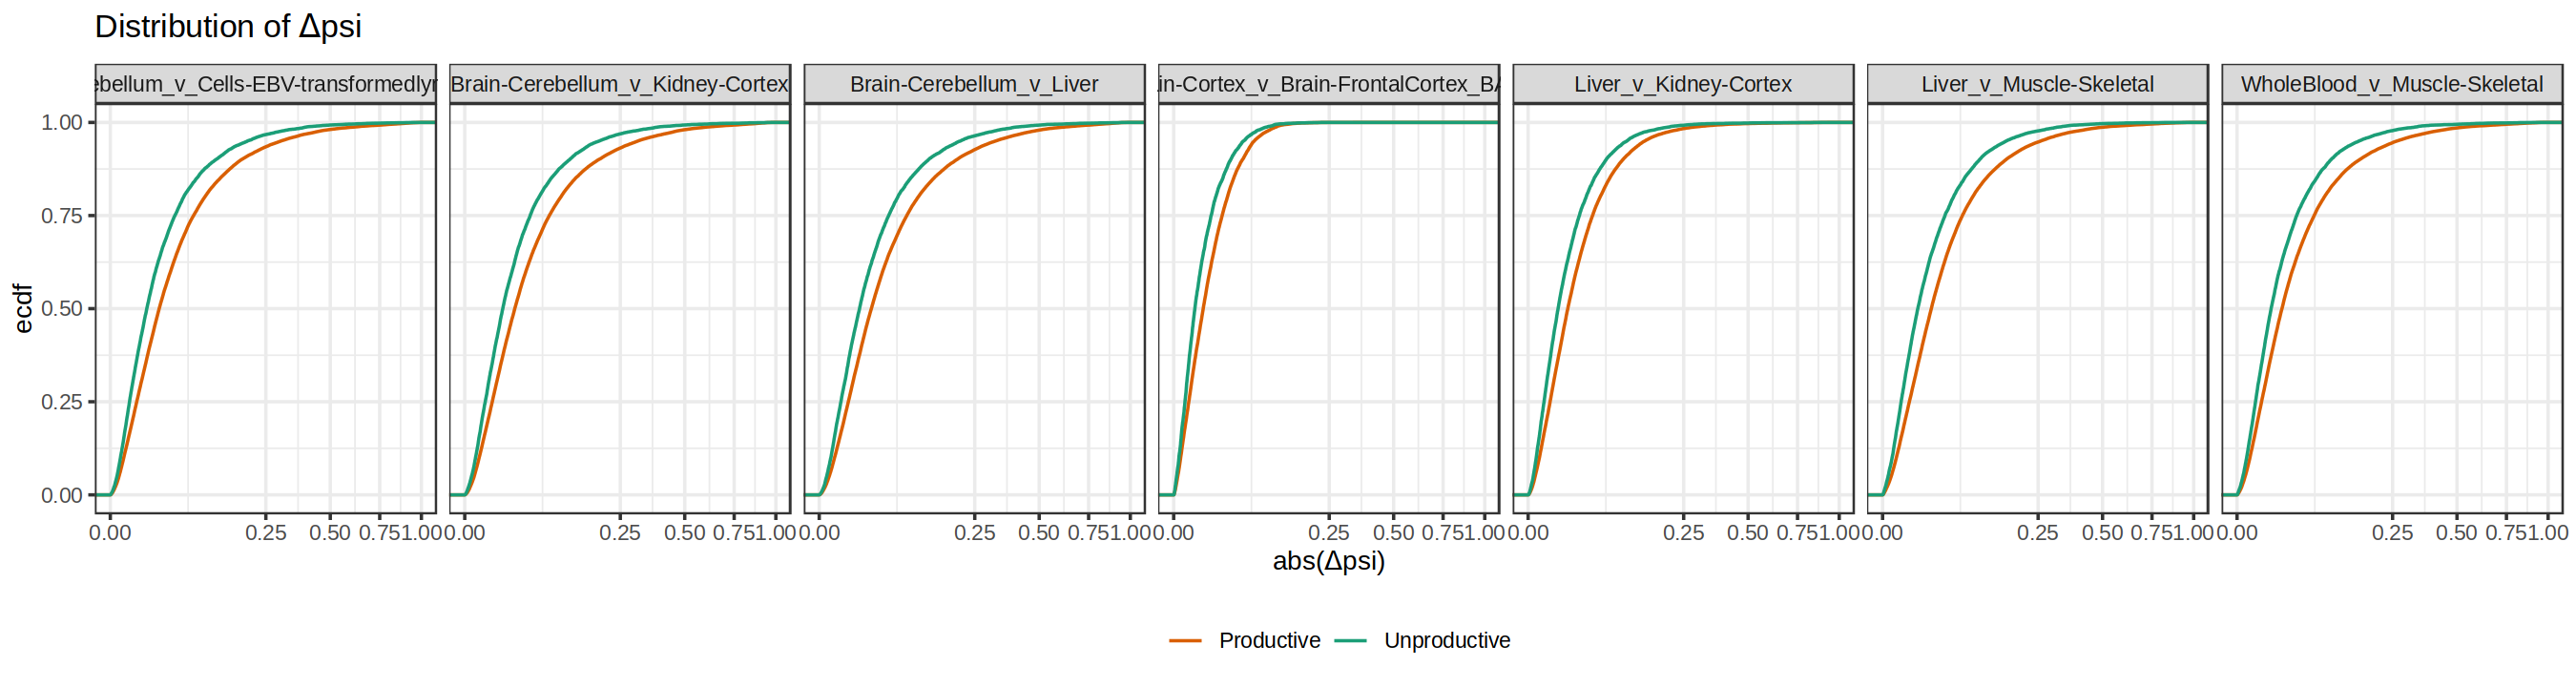

In [48]:
hist2.2

**Interpretation:**

- productive clusters generally have larger psi changes than unproductive clusters.
    - because PR clusters reflect changes from 1 protein coding isoform to another coding isform, while UP clusters include ones that change from protein coding to unproductive. The change to unproductive is more moderate?
    - note, UP clusters must include protein coding introns, sometimes more than 1. So it's possible that differential spliced UP clusters are still clusters that shift between 1 protein coding iso to another protein isoform.
 



**PR Clusters:**
- These clusters are easy to label. Since there are only PR introns, the differential splicing of these clusters change it from 1 protein coding isoform to another.
- see table below:

In [49]:
betas.sig[[1]][ctype == 'PR'][cluster %in% c('chr1:clu_104_+', 'chr9:clu_22622_-')]

intron,logef,Brain-Cerebellum,Cells-EBV-transformedlymphocytes,deltapsi,itype,ctype,cluster
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1:5992788:5995862:clu_104_+,-0.1611220,0.004499482,0.005322675,0.0008231924,PR,PR,chr1:clu_104_+
chr1:5992788:6018634:clu_104_+,-0.6068769,0.036149809,0.027383218,-0.0087665904,PR,PR,chr1:clu_104_+
chr1:5992788:6040516:clu_104_+,-1.8457047,0.918596071,0.201598343,-0.7169977280,PR,PR,chr1:clu_104_+
chr1:6018835:6040516:clu_104_+,-1.8455455,0.034442479,0.007560072,-0.0268824074,PR,PR,chr1:clu_104_+
chr1:6026445:6040516:clu_104_+,4.4592491,0.006312159,0.758135692,0.7518235334,PR,PR,chr1:clu_104_+
chr9:109217145:109243617:clu_22622_-,-4.2596491,0.980585671,0.009979827,-0.9706058441,PR,PR,chr9:clu_22622_-
chr9:109241809:109243617:clu_22622_-,4.2596491,0.019414329,0.990020173,0.9706058441,PR,PR,chr9:clu_22622_-


**UP Clusters:**
- if there is only 1 PR intron, then the changes have to go between the PR intron to 1 or more UP introns
- if there are more than 1 PR introns, then the changes can
    - go between the PR introns, which is not inducing NMD
    - go from PR introns to UP introns

Warning message:
“Removed 4 rows containing non-finite values (`stat_ecdf()`).”


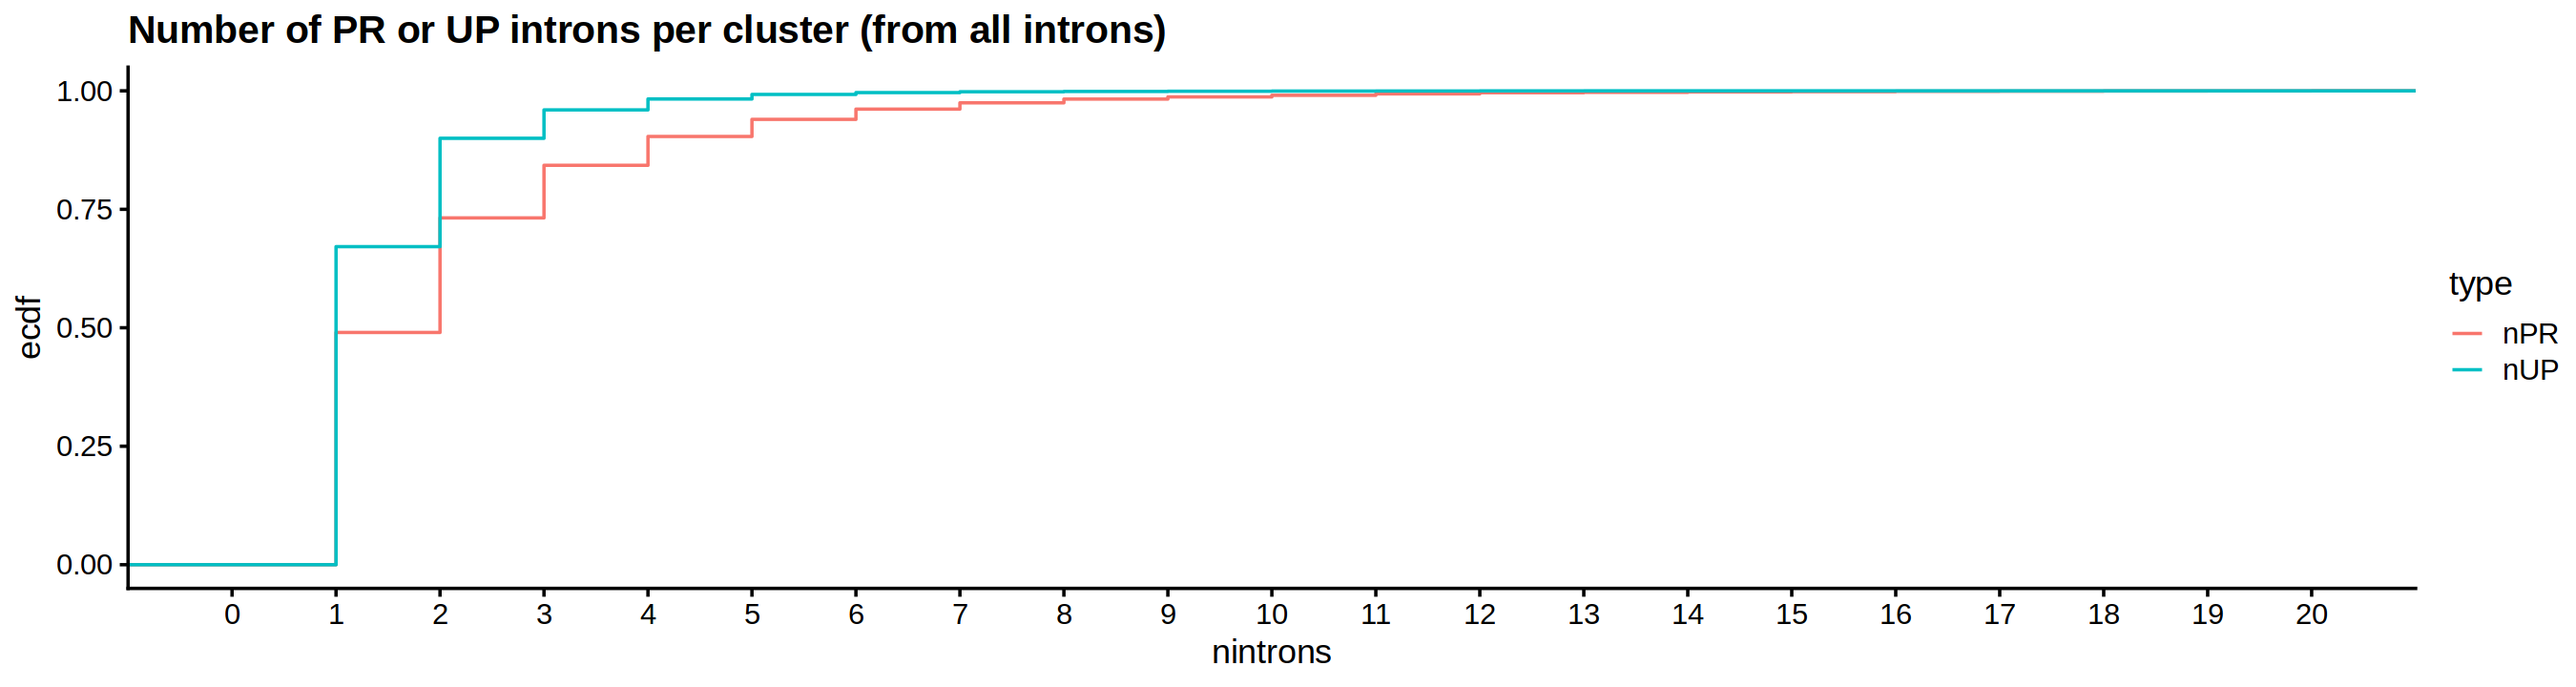

In [50]:
betas[[1]][ctype == 'PR,UP'] %>% 
    .[, .(intron, logef, `Brain-Cerebellum`, `Cells-EBV-transformedlymphocytes`,
          deltapsi, itype, ctype, 
          nPR = sum(str_detect(itype, "PR")),
          nUP = sum(str_detect(itype, 'UP'))
         ), by = cluster] %>% 
    .[, .(cluster, nPR, nUP)] %>% unique %>% 
    melt(id.vars = "cluster", variable.name = "type", value.name = "nintrons") %>% 
    ggplot() + stat_ecdf(aes(nintrons, color = type)) +
        scale_x_continuous(limits = c(0,20), breaks = seq(0,20,1), labels = seq(0,20,1)) +
        labs(title = "Number of PR or UP introns per cluster (from all introns)")

Warning message:
“Removed 4 rows containing non-finite values (`stat_ecdf()`).”


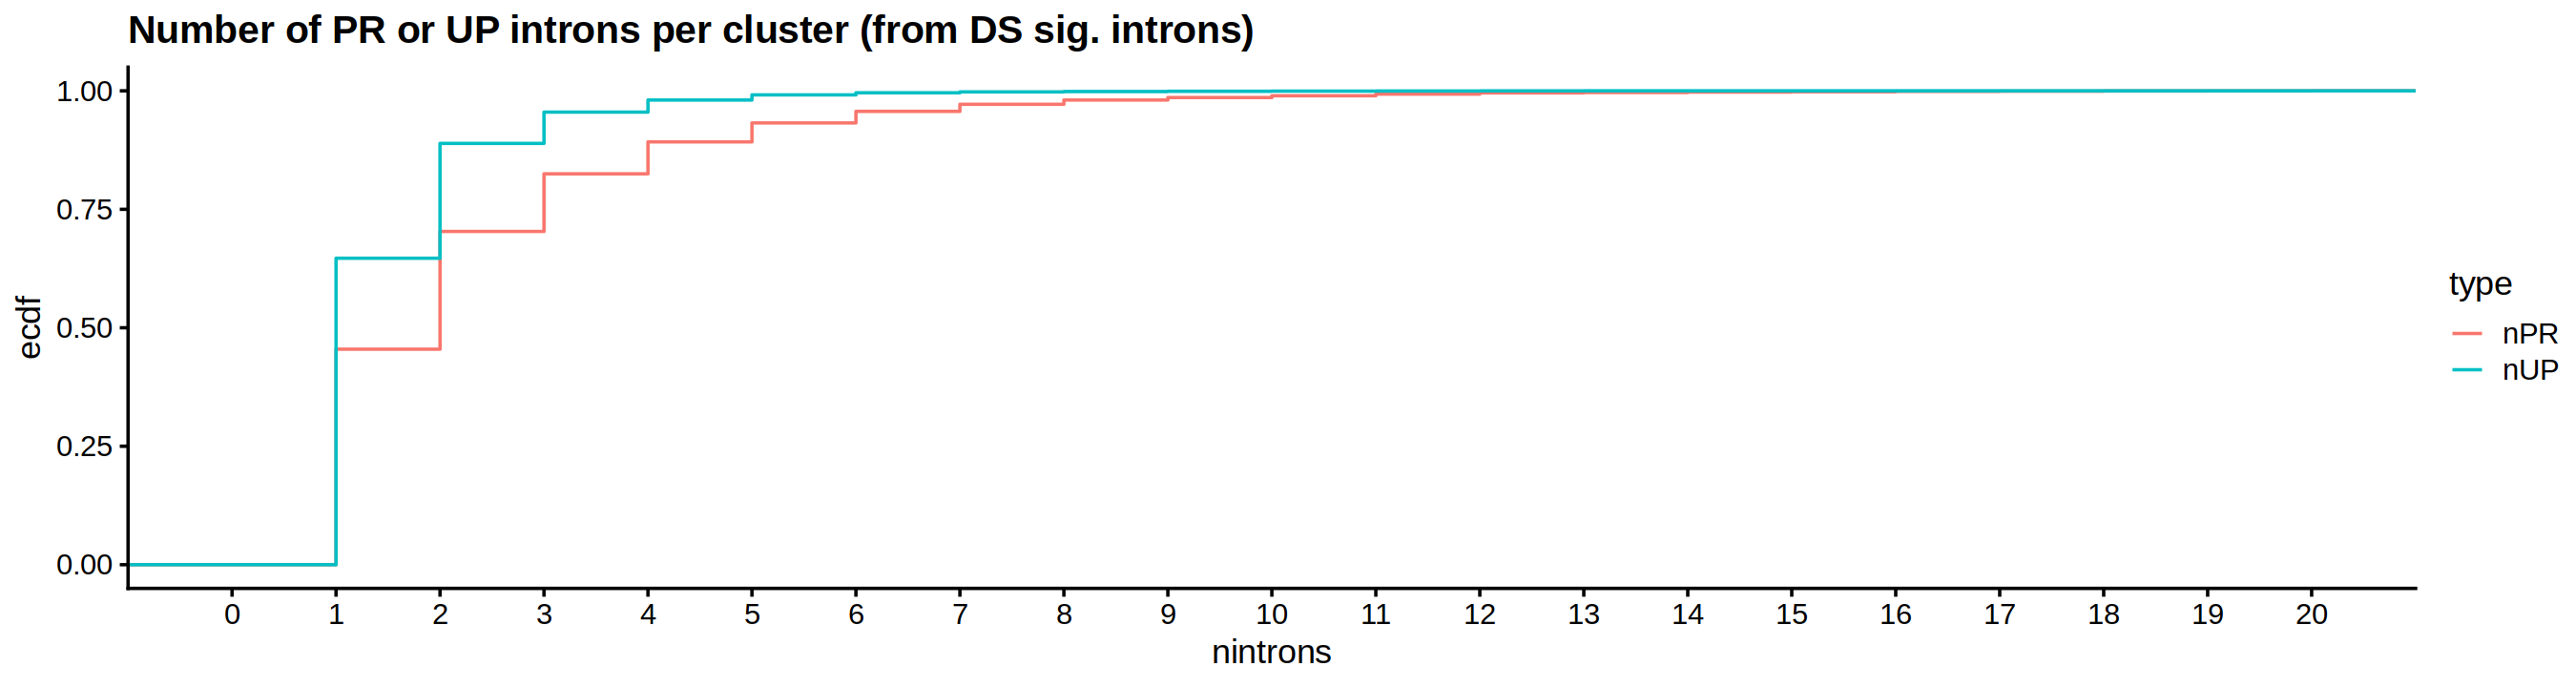

In [51]:
betas.sig[[1]][ctype == 'PR,UP'] %>% 
    .[, .(intron, logef, `Brain-Cerebellum`, `Cells-EBV-transformedlymphocytes`,
          deltapsi, itype, ctype, 
          nPR = sum(str_detect(itype, "PR")),
          nUP = sum(str_detect(itype, 'UP'))
         ), by = cluster] %>% 
    .[, .(cluster, nPR, nUP)] %>% unique %>% 
    melt(id.vars = "cluster", variable.name = "type", value.name = "nintrons") %>% 
    ggplot() + stat_ecdf(aes(nintrons, color = type)) +
        scale_x_continuous(limits = c(0,20), breaks = seq(0,20,1), labels = seq(0,20,1)) +
        labs(title = "Number of PR or UP introns per cluster (from DS sig. introns)")

just look at effect sizes from introns that are significantly ds

DS logic: 
- `if ctype == 'PR': dstype = 'AS-NMD'`
- `if ctype == 'PR,UP' AND nPR == 1: dstype = 'AS-NMD'`
- `if ctype == PR,UP' AND nPR > 1 AND total abs(deltapsi) of PR introns < total abs(deltapsi) of UP introns: dstype = 'AS-NMD'`
- Otherwise, all ctype == 'PR', or 'PR,UP' clusters are 'AS-PR', alternative isoform for protein coding transcripts

**Table below shows `PR,UP` clusters with >1 PR introns**

- use sum of abs(deltapsi) by intron type (PR vs. UP)
- if sum(abs(deltapsi)) of PR introns > than those of UP introns, it means that
most introns that have significant change are PR introns, thus consider this cluster
as largely alternative splicing for protein coding isoforms
- otherwise, it means AS PR introns change to UP introns, thus induce AS-NMD

In [53]:
labelClusterDStype <- function(dt) {
    # dt: significant introns in effect size data.table

    # ensure only "PR", "PR,UP" ctypes
    dt <- dt[ctype %in% c('PR', 'PR,UP')]
    dt[, nPR := sum(str_detect(itype, 'PR')), by = cluster] # compute number of PR introns per cluster
    # label dstype
    dt[, dstype1 := case_when(
        ctype == 'PR' ~ 'AS-PR',
        ctype == 'PR,UP' & nPR == 1 ~ 'AS-NMD',
        TRUE ~ 'TBD'
    )]
    # subset dt where dstype1 == 'TBD'
    dt2 <- dt[dstype1 == 'TBD', .(cluster, intron, itype, ctype, dstype1, deltapsi)
             ][, .(adpsi = sum(abs(deltapsi))), by = .(cluster, itype)] %>% # compute abs(deltapsi) by cluster, introntype
            dcast(cluster~itype, value.var = 'adpsi') %>%
            .[, .(cluster, PR, UP, dstype2 = if_else(PR > UP, "AS-PR", "AS-NMD"))] # label dstype based on which has larger abs(deltapsi)
    
    dt <- left_join(dt, dt2[, .(cluster, dstype2)], by = 'cluster') # bring in dstype2 for TBD introns
    dt[, dstype := if_else(dstype1 == "TBD", dstype2, dstype1)]
    dt <- dt[, -c("dstype1", "dstype2")]
    return(dt)
}

In [54]:

# annotated effect size dataframes
betas.sig2 <- map(betas.sig, labelClusterDStype)

Warning message in `[.data.table`(dt, , `:=`(dstype, if_else(dstype1 == "TBD", dstype2, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”
Warning message in `[.data.table`(dt, , `:=`(dstype, if_else(dstype1 == "TBD", dstype2, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avo

In [55]:
betas.sig2[[1]] %>% head

intron,logef,Brain-Cerebellum,Cells-EBV-transformedlymphocytes,deltapsi,itype,ctype,cluster,nPR,dstype
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>
chr1:75724817:75728388:clu_1002_+,0.7081498,0.003776209,0.0062080438,0.002431835,PR,PR,chr1:clu_1002_+,4,AS-PR
chr1:75724817:75728400:clu_1002_+,0.3671185,0.376768275,0.4404180135,0.063649738,PR,PR,chr1:clu_1002_+,4,AS-PR
chr1:75724817:75732643:clu_1002_+,-1.3719115,0.137389785,0.0282159100,-0.109173875,PR,PR,chr1:clu_1002_+,4,AS-PR
chr1:75728488:75732643:clu_1002_+,0.2966433,0.482065731,0.5251580327,0.043092302,PR,PR,chr1:clu_1002_+,4,AS-PR
chr1:75732922:75733050:clu_1003_+,-1.0966370,0.014190861,0.0007684111,-0.013422450,PR,PR,chr1:clu_1003_+,6,AS-PR
chr1:75732922:75733527:clu_1003_+,2.0576235,0.412621026,0.5236174763,0.110996450,PR,PR,chr1:clu_1003_+,6,AS-PR


In [56]:
imap_dfr(betas.sig2, ~.x[, .(N = uniqueN(cluster)), by = dstype][, .(grp = .y, dstype, N)]) %>% 
    .[!is.na(dstype)] %>% 
    .[, .(dstype, N, P = N/sum(N)), by = grp]

grp,dstype,N,P
<chr>,<chr>,<int>,<dbl>
Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,AS-PR,16580,0.7683752
Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,AS-NMD,4998,0.2316248
Brain-Cerebellum_v_Kidney-Cortex,AS-PR,15586,0.7708972
Brain-Cerebellum_v_Kidney-Cortex,AS-NMD,4632,0.2291028
Brain-Cerebellum_v_Liver,AS-PR,15742,0.7689527
Brain-Cerebellum_v_Liver,AS-NMD,4730,0.2310473
Liver_v_Kidney-Cortex,AS-PR,10831,0.7901802
Liver_v_Kidney-Cortex,AS-NMD,2876,0.2098198
Liver_v_Muscle-Skeletal,AS-PR,15931,0.7847397


In [57]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 180)

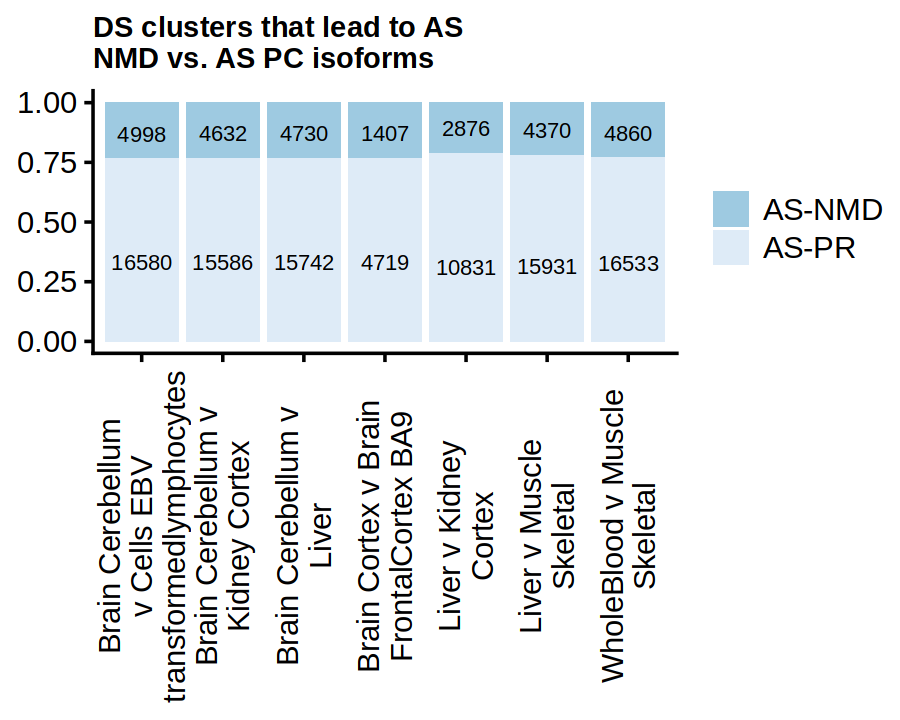

In [58]:
imap_dfr(betas.sig2, ~.x[, .(N = uniqueN(cluster)), by = dstype][, .(grp = .y, dstype, N)]) %>% 
    .[!is.na(dstype)] %>% 
    .[, .(dstype, N, P = N/sum(N)), by = grp]  %>% 
    ggplot() + geom_col(aes(x = grp, y = P, fill = dstype)) +
        geom_text(aes(x = grp, y = (1-P) + .1, label = N), size = 3) +
        scale_x_discrete(name = NULL, label = relabelLong) +
        scale_fill_brewer(name = NULL, palette = "Blues", direction = -1) +
        labs(y = NULL, title = relabelLong("DS clusters that lead to AS-NMD vs. AS PC isoforms", 30)) +
        theme(axis.text.x = element_text(angle = 90, vjust = .5),
              title = element_text(size = 10)
             )

## Distribution of AS-NMD vs. AS-PR introns

In [59]:
betas.sig2[[1]][, .N, by = .(dstype, itype)]

dstype,itype,N
<chr>,<chr>,<int>
AS-PR,PR,57573
AS-PR,UP,6924
AS-NMD,UP,7706
AS-NMD,PR,5894


In [60]:
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 180)

In [61]:
hist3 <- imap_dfr(betas.sig2, ~ .x[, .(intron, cluster, dstype, itype, ctype, deltapsi, grp=.y)]) %>%
    .[!is.na(dstype)] %>% 
    mutate(linecolor = paste(dstype, itype, sep=":")) %>% 
    ggplot() + stat_ecdf(aes(x = abs(deltapsi), color = linecolor)) +
        scale_x_continuous(trans = "sqrt", breaks = c(seq(0,.3, .1), .5, .75, 1)) +
        theme_bw() + 
        theme(legend.position = "bottom", legend.title = element_blank()) +
        facet_wrap(~grp, nrow = 1)

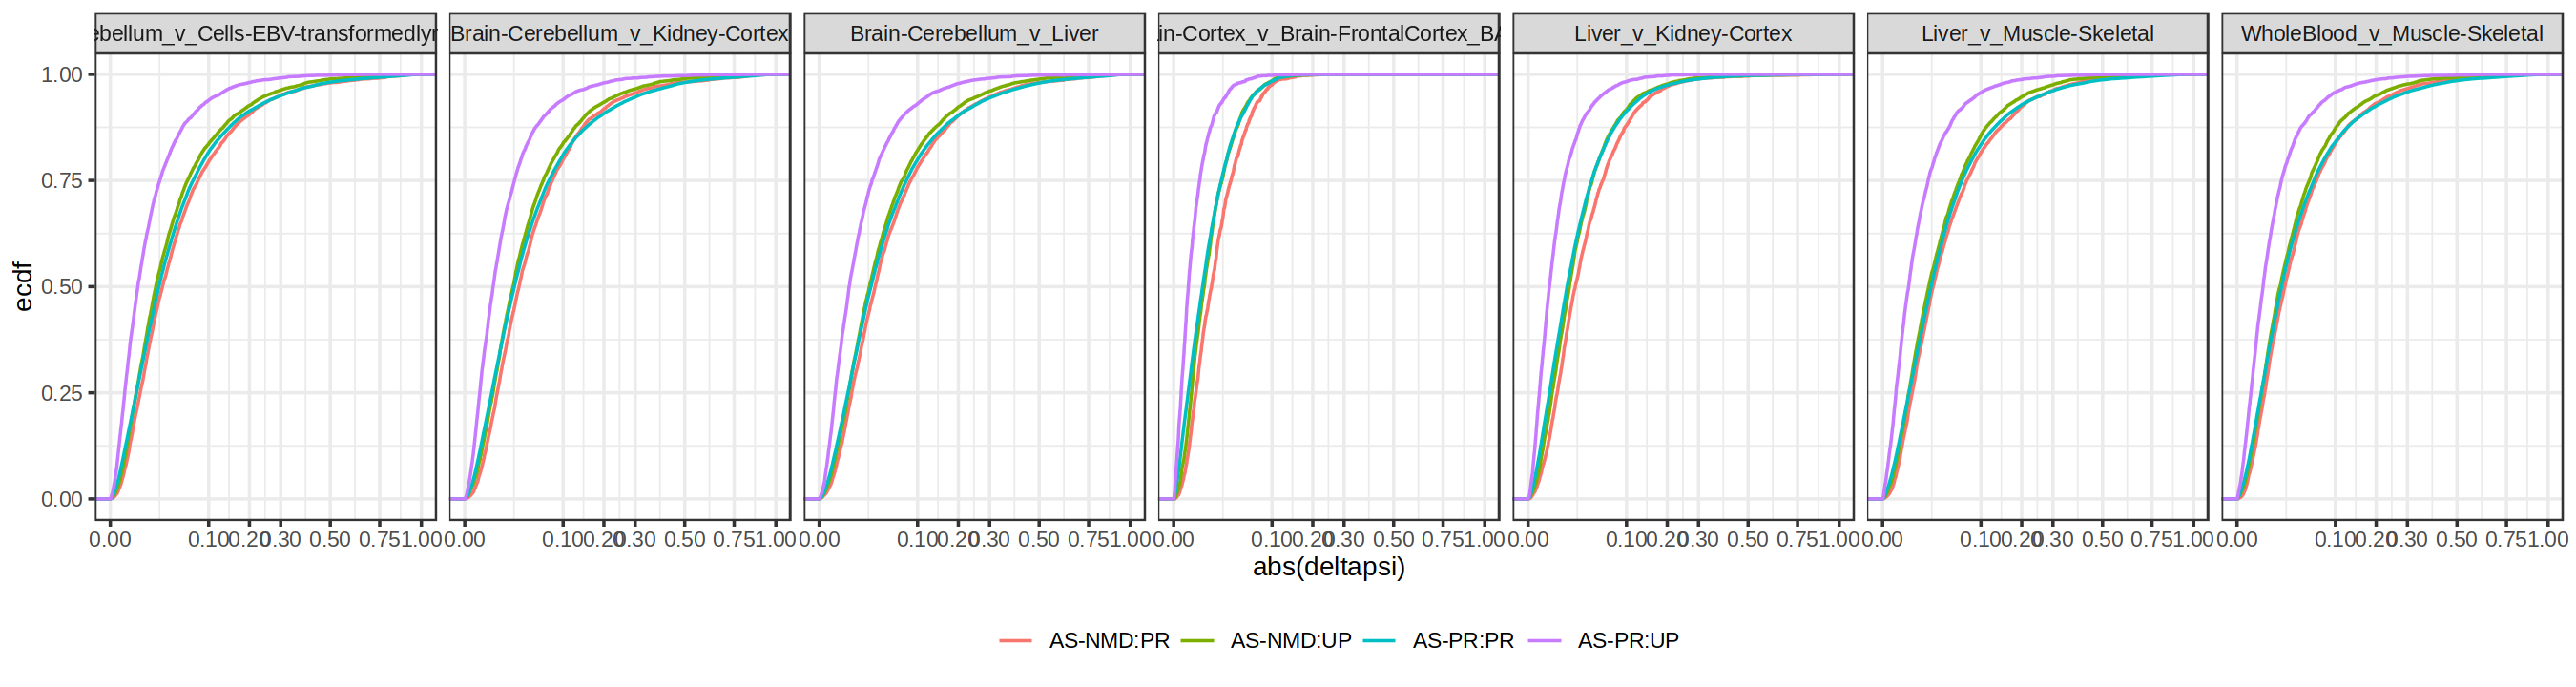

In [62]:
hist3

**Interpretation:**

1. generally consistent trend with the previous plot where only differentiating introns from PR groups vs. introns from PR,UP groups
2. AS-NMD:PR and AS-PR both result in protein coding transcripts. These PR introns generally have larger abs(deltapsi)
3. UP introns generally have smaller delta psi.
4. Note howevefer, in AS-PR clusters, where there are both PR introns and UP introns, often larger delta PSI of PR introns are resulted from many UP introns with small deltaPSI (result of aggregation)

## select top DS clusters and compare gene expressions

- can split between UP and PR

In [63]:
th_adpsi = 0.1 # abs(deltapsi) threshold for selecting introns for plotting

In [64]:
# rank deltpsi
map(betas.sig2, ~.x[abs(deltapsi) > th_adpsi, .N, by= .(dstype, itype)][order(dstype, itype)])

dstype,itype,N
<chr>,<chr>,<int>
AS-NMD,PR,1213
AS-NMD,UP,1263
AS-PR,PR,10552
AS-PR,UP,424
dstype,itype,N
<chr>,<chr>,<int>
AS-NMD,PR,1120
AS-NMD,UP,1162
AS-PR,PR,10157


In [65]:
# select introns that pass min abs(deltapsi), used for subsequent plotting against expression

plot_introns <- imap_dfr(betas.sig2, ~.x[abs(deltapsi) > th_adpsi, .(cluster, intron, deltapsi, itype, ctype, nPR, dstype, grp = .y)])

In [66]:
head(plot_introns)

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>
chr1:clu_1002_+,chr1:75724817:75732643:clu_1002_+,-0.1091739,PR,PR,4,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes
chr1:clu_1003_+,chr1:75732922:75733527:clu_1003_+,0.1109965,PR,PR,6,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes
chr1:clu_1006_+,chr1:75786274:75787496:clu_1006_+,-0.1970952,PR,"PR,UP",2,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes
chr1:clu_1019_+,chr1:77918273:77926413:clu_1019_+,-0.1089903,PR,PR,3,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes
chr1:clu_1021_+,chr1:78080860:78092756:clu_1021_+,-0.9271973,UP,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes
chr1:clu_1021_+,chr1:78080860:78094951:clu_1021_+,0.9271973,PR,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes


In [67]:
plot_introns_to_bed <- str_split(plot_introns$intron, ":", simplify = T) %>% as.data.table
names(plot_introns_to_bed) <- c("seqname", "start", "end", "cluster")
plot_introns_to_bed[, `:=`(cluster = paste(seqname, cluster, sep=":"), strand = str_sub(cluster, -1, -1))]

In [68]:
plot_introns_to_bed <- makeGRangesFromDataFrame(plot_introns_to_bed, keep.extra.columns = T, ignore.strand = F, starts.in.df.are.0based = T)

In [69]:
olaps <- findOverlaps(plot_introns_to_bed, genes, minoverlap = 50, select = 'first')

In [70]:
mcols(plot_introns_to_bed) <- mcols(plot_introns_to_bed) %>%  # add gene info
    as_tibble %>% 
    cbind(mcols(genes[olaps]))

In [71]:
if (all(plot_introns_to_bed$cluster == plot_introns$cluster)) {
    print("do")
    plot_introns <- cbind(plot_introns, as.data.table(mcols(plot_introns_to_bed)[, c('gene_name', 'gene_id')]))
}

[1] "do"


Now, this table is ready to get leafcutter counts and tpm

In [72]:
plot_introns[1:5]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr1:clu_1002_+,chr1:75724817:75732643:clu_1002_+,-0.1091739,PR,PR,4,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15
chr1:clu_1003_+,chr1:75732922:75733527:clu_1003_+,0.1109965,PR,PR,6,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15
chr1:clu_1006_+,chr1:75786274:75787496:clu_1006_+,-0.1970952,PR,"PR,UP",2,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15
chr1:clu_1019_+,chr1:77918273:77926413:clu_1019_+,-0.1089903,PR,PR,3,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,NEXN,ENSG00000162614.19
chr1:clu_1021_+,chr1:78080860:78092756:clu_1021_+,-0.9271973,UP,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,GIPC2,ENSG00000137960.6


In [73]:
names(introns)

[1] "Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes"
[2] "Brain-Cerebellum_v_Kidney-Cortex"                   
[3] "Brain-Cerebellum_v_Liver"                           
[4] "Liver_v_Kidney-Cortex"                              
[5] "Liver_v_Muscle-Skeletal"                            
[6] "Brain-Cortex_v_Brain-FrontalCortex_BA9_"            
[7] "WholeBlood_v_Muscle-Skeletal"

In [80]:
tissues <- c("Brain-Cerebellum", "Cells-EBV-transformedlymphocytes",
            "Kidney-Cortex", "Liver", "Muscle-Skeletal", "Brain-Cortex", 
             "Brain-FrontalCortex_BA9_", "WholeBlood")
tpm.f <- paste("../code/resources/GTEx/expression/", tissues, "_gene_tpm.tsv.gz", sep="")
names(tpm.f) <- tissues

In [81]:
tpm.f

Brain-Cerebellum 
                "../code/resources/GTEx/expression/Brain-Cerebellum_gene_tpm.tsv.gz" 
                                                    Cells-EBV-transformedlymphocytes 
"../code/resources/GTEx/expression/Cells-EBV-transformedlymphocytes_gene_tpm.tsv.gz" 
                                                                       Kidney-Cortex 
                   "../code/resources/GTEx/expression/Kidney-Cortex_gene_tpm.tsv.gz" 
                                                                               Liver 
                           "../code/resources/GTEx/expression/Liver_gene_tpm.tsv.gz" 
                                                                     Muscle-Skeletal 
                 "../code/resources/GTEx/expression/Muscle-Skeletal_gene_tpm.tsv.gz" 
                                                                        Brain-Cortex 
                    "../code/resources/GTEx/expression/Brain-Cortex_gene_tpm.tsv.gz" 
                                                            Brain-FrontalCortex_BA9_ 
        "../code/resources/GTEx/expression/Brain-FrontalCortex_BA9__gene_tpm.tsv.gz" 
                                                                          WholeBlood 
                      "../code/resources/GTEx/expression/WholeBlood_gene_tpm.tsv.gz"

In [82]:
tpm <- map(tpm.f, fread)

In [83]:
# compute median tpm per gene
tpm <- map(tpm, ~.x[, .(Name, Description, medTPM = matrixStats::rowMedians(as.matrix(.SD))), .SDcols = names(.x)[-c(1:2)]])

In [84]:
names(tpm)

[1] "Brain-Cerebellum"                 "Cells-EBV-transformedlymphocytes"
[3] "Kidney-Cortex"                    "Liver"                           
[5] "Muscle-Skeletal"                  "Brain-Cortex"                    
[7] "Brain-FrontalCortex_BA9_"         "WholeBlood"

In [85]:
tpm[[1]][1:2]

Name,Description,medTPM
<chr>,<chr>,<dbl>
ENSG00000223972.5,DDX11L1,0.000
ENSG00000227232.5,WASH7P,5.721


leafcutter numerators

In [86]:
getMedianLFcounts <- function(f) {
    # f: leafcutter count file for ds, eg.. results/ds/GTEx/Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes/ds_perind_numers.counts.noise_by_intron.lf1.gz

    # leafcutter counts
    dt <- fread(f)
    
    header <- names(dt)

    # 2 group names
    groups <- header[-c(1)] %>% str_split('\\.') %>% map_chr(1) %>% unique

    # colnames for each group
    group1_cols <- header[str_detect(header, groups[1])]
    group2_cols <- header[str_detect(header, groups[2])]

    # new cole name for each group
    t1 <- groups[[1]]
    t2 <- groups[[2]]

    # compute row medians by group
    med1 <- dt[, ..group1_cols] %>% as.matrix %>% matrixStats::rowMedians(.)
    med2 <- dt[, ..group2_cols] %>% as.matrix %>% matrixStats::rowMedians(.)

    # output dt
    dt2 <- dt[, .(chrom)]
    dt2[, (t1) := med1]
    dt2[, (t2) := med2]

    return(dt2[])
}

In [87]:
counts.f <- paste("../code/results/ds/GTEx/", comps, "/ds_perind_numers.counts.noise_by_intron.gz", sep="")
names(counts.f)  <- comps

In [88]:
counts <- map(counts.f, getMedianLFcounts)

In [89]:
head(counts[[1]])

chrom,Brain-Cerebellum,Cells-EBV-transformedlymphocytes
<chr>,<dbl>,<dbl>
chr1:779092:781936:clu_3_+:IN,0,0
chr1:779092:803918:clu_3_+:IN,0,0
chr1:804222:804775:clu_5_+:IN,1,1
chr1:804222:807216:clu_5_+:IN,0,0
chr1:804966:807216:clu_5_+:IN,0,0
chr1:807323:809657:clu_6_+:IN,0,0


In [90]:
head(plot_introns)

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr1:clu_1002_+,chr1:75724817:75732643:clu_1002_+,-0.1091739,PR,PR,4,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15
chr1:clu_1003_+,chr1:75732922:75733527:clu_1003_+,0.1109965,PR,PR,6,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15
chr1:clu_1006_+,chr1:75786274:75787496:clu_1006_+,-0.1970952,PR,"PR,UP",2,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15
chr1:clu_1019_+,chr1:77918273:77926413:clu_1019_+,-0.1089903,PR,PR,3,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,NEXN,ENSG00000162614.19
chr1:clu_1021_+,chr1:78080860:78092756:clu_1021_+,-0.9271973,UP,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,GIPC2,ENSG00000137960.6
chr1:clu_1021_+,chr1:78080860:78094951:clu_1021_+,0.9271973,PR,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,GIPC2,ENSG00000137960.6


## DS up deltapsi in Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes

In [91]:
# gather data

dt_scatter1 <- plot_introns[grp == 'Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes']

In [92]:
# BC vs. LCL on median tpm (L2FC)

l2fc1 <- inner_join(x = tpm[['Brain-Cerebellum']],
           y = tpm[['Cells-EBV-transformedlymphocytes']],
           by = c("Name", "Description"),
           suffix = c("_BC", "_LCL")
          ) %>% 
.[, .(Name, Description, medTPM_BC, medTPM_LCL, l2fc = log2(medTPM_LCL/medTPM_BC))] %>% 
.[!is.na(l2fc) & abs(l2fc) != Inf]

In [93]:
dt_scatter1[1:2]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr1:clu_1002_+,chr1:75724817:75732643:clu_1002_+,-0.1091739,PR,PR,4,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15
chr1:clu_1003_+,chr1:75732922:75733527:clu_1003_+,0.1109965,PR,PR,6,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15


In [94]:
l2fc1[1:2]

Name,Description,medTPM_BC,medTPM_LCL,l2fc
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ENSG00000227232.5,WASH7P,5.72100,2.494500,-1.1975167
ENSG00000186092.4,OR4F5,0.05772,0.030985,-0.8975013


In [95]:
dt_scatter1 <- left_join(x = dt_scatter1, 
                         y = l2fc1[, .(gene_name = Description, l2fc)],
                         by = 'gene_name') %>% 
    .[!is.na(l2fc) & abs(l2fc) > 1 & abs(l2fc) != Inf]

Warning message in left_join(x = dt_scatter1, y = l2fc1[, .(gene_name = Description, :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 941 of `x` matches multiple rows in `y`.
ℹ Row 1025 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [96]:
dt_scatter1[1:5]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id,l2fc
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
chr1:clu_1002_+,chr1:75724817:75732643:clu_1002_+,-0.1091739,PR,PR,4,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15,2.024617
chr1:clu_1003_+,chr1:75732922:75733527:clu_1003_+,0.1109965,PR,PR,6,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15,2.024617
chr1:clu_1006_+,chr1:75786274:75787496:clu_1006_+,-0.1970952,PR,"PR,UP",2,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ACADM,ENSG00000117054.15,2.024617
chr1:clu_1019_+,chr1:77918273:77926413:clu_1019_+,-0.1089903,PR,PR,3,AS-PR,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,NEXN,ENSG00000162614.19,1.429009
chr1:clu_1021_+,chr1:78080860:78092756:clu_1021_+,-0.9271973,UP,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,GIPC2,ENSG00000137960.6,-2.197214


In [97]:
dt_scatter1 %>% dim

[1] 7446   11

In [98]:
cortest1 <- dt_scatter1[, .(deltapsi, l2fc, itype)] %>% 
    split(by = c("itype")) %>% 
    map(~.x %$% cor.test(l2fc, deltapsi, method = 'p'))

In [99]:
cortest1.df <- data.table(itype = names(cortest1),
           pval = map_dbl(cortest1, ~.x[['p.value']]),
           cor = map_dbl(cortest1, ~.x[['estimate']])
          ) %>% 
    add_column(label = glue::glue("corr: {scales::number(.$cor, .001)}, p: {scales::scientific(.$pval, 2)}"))

In [100]:
cortest1 %>% print
cortest1.df

$PR

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = 2.7379, df = 6524, p-value = 0.0062
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.009622832 0.058092576
sample estimates:
       cor 
0.03387762 


$UP

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = -8.2125, df = 918, p-value = 7.313e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3208213 -0.2003671
sample estimates:
       cor 
-0.2616126 




itype,pval,cor,label
<chr>,<dbl>,<dbl>,<glue>
PR,6.199854e-03,0.03387762,"corr: 0.034, p: 6.2e-03"
UP,7.312529e-16,-0.26161256,"corr: -0.262, p: 7.3e-16"


In [101]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 180)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 80 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 80 rows containing missing values (`geom_point()`).”


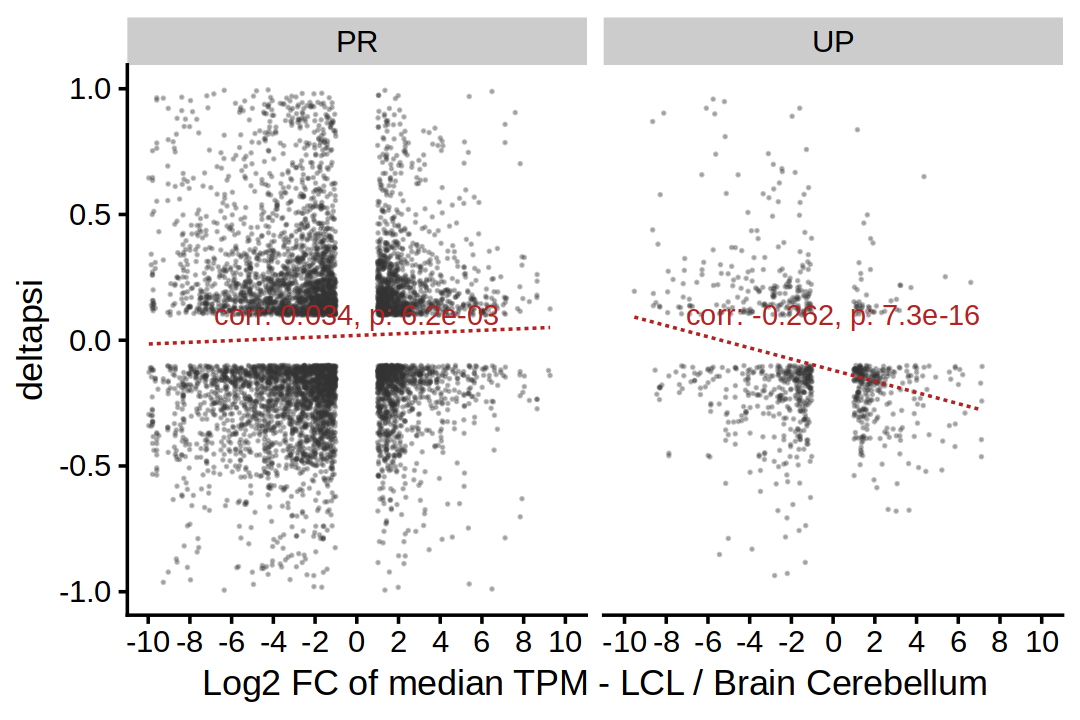

In [102]:
dt_scatter1 %>% 
    ggplot() + geom_point(aes(l2fc, deltapsi), alpha = .3, color = 'grey20', size = .1) +
        geom_smooth(aes(l2fc, deltapsi), method = "lm", formula = 'y~x', se = F, linetype = 'dashed', size =.5, color = 'firebrick') +
        geom_text(aes(x = 0, y = .1, label = label), data = cortest1.df, color = 'firebrick', size = 4) + 
        scale_x_continuous(limits = c(-10, 10), breaks = seq(-10,10,2)) +
        labs(x = 'Log2 FC of median TPM - LCL / Brain Cerebellum') +
        facet_wrap(~itype, nrow=1)

## DS up deltapsi in Liver_v_Muscle-Skeletal

In [103]:
# gather data

dt_scatter2 <- plot_introns[grp == 'Liver_v_Muscle-Skeletal']

In [104]:
# BC vs. LCL on median tpm (L2FC)

l2fc2 <- inner_join(x = tpm[['Liver']],
           y = tpm[['Muscle-Skeletal']],
           by = c("Name", "Description"),
           suffix = c("_Liver", "_Muscle")
          ) %>% 
.[, .(Name, Description, medTPM_Liver, medTPM_Muscle, l2fc = log2(medTPM_Muscle/medTPM_Liver))] %>% 
.[!is.na(l2fc) & abs(l2fc) != Inf]

In [105]:
dt_scatter2[1:2]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr1:clu_1018_+,chr1:77916133:77917565:clu_1018_+,0.2778550,PR,PR,3,AS-PR,Liver_v_Muscle-Skeletal,NEXN,ENSG00000162614.19
chr1:clu_1018_+,chr1:77916133:77917959:clu_1018_+,-0.5767754,PR,PR,3,AS-PR,Liver_v_Muscle-Skeletal,NEXN,ENSG00000162614.19


In [106]:
l2fc2[1:2]

Name,Description,medTPM_Liver,medTPM_Muscle,l2fc
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ENSG00000227232.5,WASH7P,1.76550,1.41700,-0.3172371
ENSG00000268020.3,OR4G4P,0.03327,0.03752,0.1734380


In [107]:
dt_scatter2 <- left_join(x = dt_scatter2, 
                         y = l2fc2[, .(gene_name = Description, l2fc)],
                         by = 'gene_name') %>% 
    .[!is.na(l2fc) & abs(l2fc) > 1 & abs(l2fc) != Inf]

Warning message in left_join(x = dt_scatter2, y = l2fc2[, .(gene_name = Description, :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 849 of `x` matches multiple rows in `y`.
ℹ Row 1003 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [108]:
dt_scatter2[1:5]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id,l2fc
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
chr1:clu_1018_+,chr1:77916133:77917565:clu_1018_+,0.2778550,PR,PR,3,AS-PR,Liver_v_Muscle-Skeletal,NEXN,ENSG00000162614.19,7.251513
chr1:clu_1018_+,chr1:77916133:77917959:clu_1018_+,-0.5767754,PR,PR,3,AS-PR,Liver_v_Muscle-Skeletal,NEXN,ENSG00000162614.19,7.251513
chr1:clu_1018_+,chr1:77917757:77917959:clu_1018_+,0.2989204,PR,PR,3,AS-PR,Liver_v_Muscle-Skeletal,NEXN,ENSG00000162614.19,7.251513
chr1:clu_1019_+,chr1:77918273:77925187:clu_1019_+,-0.1699332,PR,PR,3,AS-PR,Liver_v_Muscle-Skeletal,NEXN,ENSG00000162614.19,7.251513
chr1:clu_1019_+,chr1:77918273:77926413:clu_1019_+,0.3278041,PR,PR,3,AS-PR,Liver_v_Muscle-Skeletal,NEXN,ENSG00000162614.19,7.251513


In [109]:
dim(dt_scatter2)

[1] 5352   11

In [110]:
cortest2 <- dt_scatter2[, .(deltapsi, l2fc, itype)] %>% 
    split(by = c("itype")) %>% 
    map(~.x %$% cor.test(l2fc, deltapsi, method = 'p'))

In [111]:
cortest2.df <- data.table(itype = names(cortest2),
           pval = map_dbl(cortest2, ~.x[['p.value']]),
           cor = map_dbl(cortest2, ~.x[['estimate']])
          ) %>% 
    add_column(label = glue::glue("corr: {scales::number(.$cor, .001)}, p: {scales::scientific(.$pval, 2)}"))

In [112]:
cortest2 %>% print
cortest2.df

$PR

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = 1.5325, df = 4828, p-value = 0.1255
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.006155929  0.050222530
sample estimates:
       cor 
0.02205083 


$UP

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = -4.4914, df = 520, p-value = 8.724e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2745163 -0.1092384
sample estimates:
       cor 
-0.1932479 




itype,pval,cor,label
<chr>,<dbl>,<dbl>,<glue>
PR,1.254527e-01,0.02205083,"corr: 0.022, p: 1.3e-01"
UP,8.724229e-06,-0.19324790,"corr: -0.193, p: 8.7e-06"


In [113]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 180)

Warning message:
“Removed 57 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 57 rows containing missing values (`geom_point()`).”


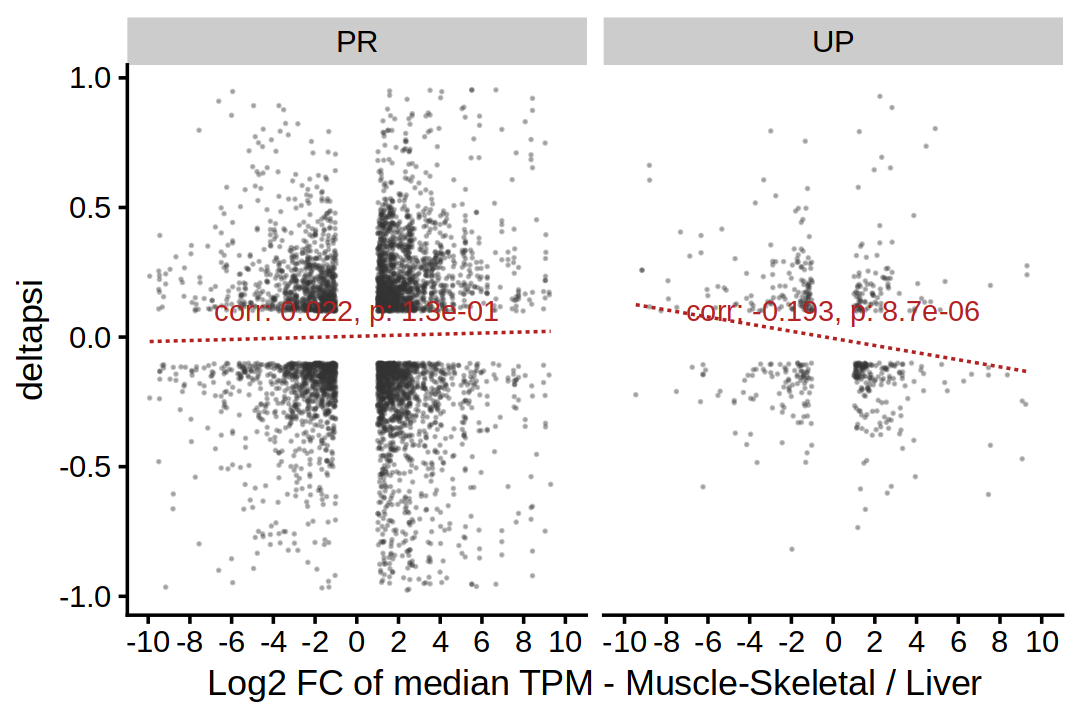

In [114]:
dt_scatter2 %>% 
    ggplot() + geom_point(aes(l2fc, deltapsi), alpha = .3, color = 'grey20', size = .1) +
        geom_smooth(aes(l2fc, deltapsi), method = "lm", formula = 'y~x', se = F, linetype = 'dashed', size =.5, color = 'firebrick') +
        geom_text(aes(x = 0, y = .1, label = label), data = cortest2.df, color = 'firebrick', size = 4) + 
        scale_x_continuous(limits = c(-10, 10), breaks = seq(-10,10,2)) +
        labs(x = 'Log2 FC of median TPM - Muscle-Skeletal / Liver') +
        facet_wrap(~itype, nrow=1)

## DS up deltapsi in Brain-Cortex_v_Brain-FrontalCortex_BA9_

In [115]:
# gather data

dt_scatter3 <- plot_introns[grp == 'Brain-Cortex_v_Brain-FrontalCortex_BA9_']
dim(dt_scatter3)

[1] 365  10

In [116]:
# BC vs. LCL on median tpm (L2FC)

l2fc3 <- inner_join(x = tpm[['Brain-Cortex']],
           y = tpm[['Brain-FrontalCortex_BA9_']],
           by = c("Name", "Description"),
           suffix = c("_BC", "_BFC")
          ) %>% 
.[, .(Name, Description, medTPM_BC, medTPM_BFC, l2fc = log2(medTPM_BFC/medTPM_BC))] %>% 
.[!is.na(l2fc) & abs(l2fc) != Inf]

In [117]:
dt_scatter3[1:2]
dim(dt_scatter3)

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr1:clu_1071_+,chr1:89525022:89568246:clu_1071_+,0.1055997,PR,PR,4,AS-PR,Brain-Cortex_v_Brain-FrontalCortex_BA9_,LRRC8B,ENSG00000197147.15
chr1:clu_1097_+,chr1:93534908:93544106:clu_1097_+,-0.1100033,PR,PR,3,AS-PR,Brain-Cortex_v_Brain-FrontalCortex_BA9_,FNBP1L,ENSG00000137942.18


[1] 365  10

In [118]:
l2fc3[1:2]
dim(l2fc3)

Name,Description,medTPM_BC,medTPM_BFC,l2fc
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ENSG00000227232.5,WASH7P,2.48300,2.14700,-0.2097621
ENSG00000243485.5,MIR1302-2HG,0.02737,0.03038,0.1505264


[1] 28849     5

In [119]:
dt_scatter3 <- left_join(x = dt_scatter3, 
                         y = l2fc3[, .(gene_name = Description, l2fc)],
                         by = 'gene_name') %>% 
    .[!is.na(l2fc) & abs(l2fc) != Inf]

In [120]:
dt_scatter3[1:5]
dt_scatter3 %>% dim

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id,l2fc
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
chr1:clu_1071_+,chr1:89525022:89568246:clu_1071_+,0.1055997,PR,PR,4,AS-PR,Brain-Cortex_v_Brain-FrontalCortex_BA9_,LRRC8B,ENSG00000197147.15,0.72192452
chr1:clu_1097_+,chr1:93534908:93544106:clu_1097_+,-0.1100033,PR,PR,3,AS-PR,Brain-Cortex_v_Brain-FrontalCortex_BA9_,FNBP1L,ENSG00000137942.18,0.24912360
chr1:clu_1243_+,chr1:112509444:112514873:clu_1243_+,0.1036938,PR,PR,4,AS-PR,Brain-Cortex_v_Brain-FrontalCortex_BA9_,WNT2B,ENSG00000134245.18,-0.07244561
chr1:clu_1533_+,chr1:155282840:155283973:clu_1533_+,-0.1235988,PR,"PR,UP",2,AS-PR,Brain-Cortex_v_Brain-FrontalCortex_BA9_,HCN3,ENSG00000143630.10,-0.27281796
chr1:clu_1533_+,chr1:155284135:155284538:clu_1533_+,0.1059561,PR,"PR,UP",2,AS-PR,Brain-Cortex_v_Brain-FrontalCortex_BA9_,HCN3,ENSG00000143630.10,-0.27281796


[1] 349  11

In [121]:
dt_scatter3 %>% dim

[1] 349  11

In [122]:
cortest3 <- dt_scatter3[, .(deltapsi, l2fc, itype)] %>% 
    split(by = c("itype")) %>% 
    map(~.x %$% cor.test(l2fc, deltapsi, method = 'p'))

In [123]:
cortest3.df <- data.table(itype = names(cortest3),
           pval = map_dbl(cortest3, ~.x[['p.value']]),
           cor = map_dbl(cortest3, ~.x[['estimate']])
          ) %>% 
    add_column(label = glue::glue("corr: {scales::number(.$cor, .001)}, p: {scales::scientific(.$pval, 2)}"))

In [124]:
cortest3 %>% print
cortest3.df

$PR

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = -0.20403, df = 307, p-value = 0.8385
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1230612  0.1000633
sample estimates:
       cor 
-0.0116439 


$UP

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = -1.3307, df = 38, p-value = 0.1912
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4902886  0.1075741
sample estimates:
       cor 
-0.2110061 




itype,pval,cor,label
<chr>,<dbl>,<dbl>,<glue>
PR,0.8384642,-0.0116439,"corr: -0.012, p: 8.4e-01"
UP,0.1912213,-0.2110061,"corr: -0.211, p: 1.9e-01"


In [125]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 180)

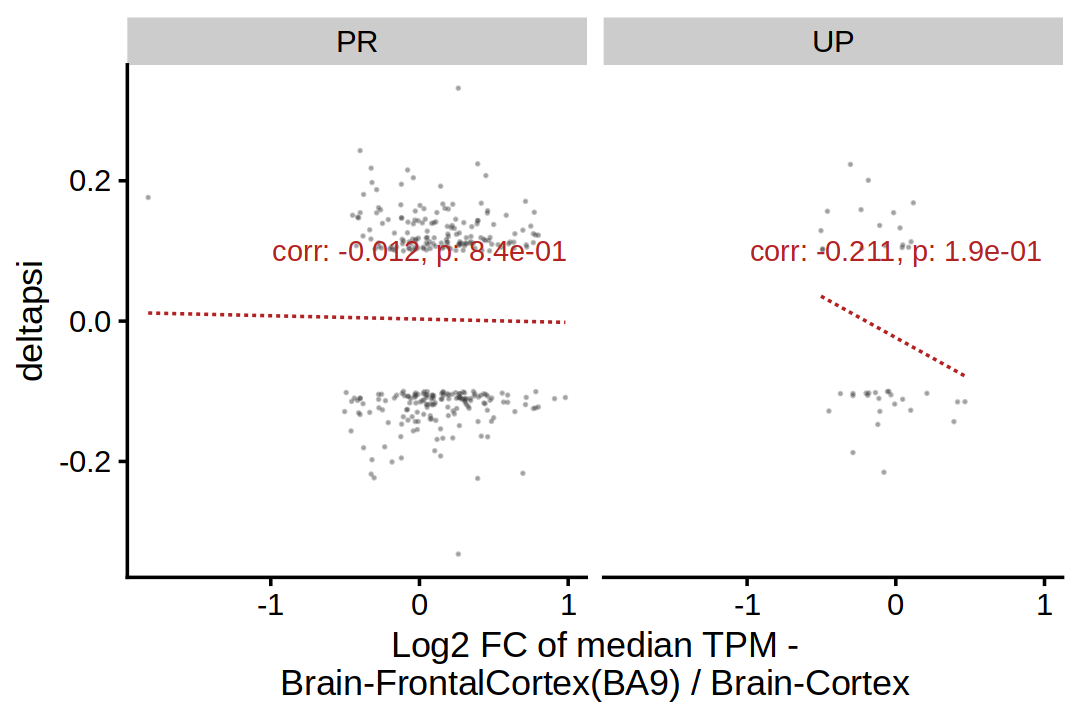

In [126]:
dt_scatter3 %>% 
    ggplot() + geom_point(aes(l2fc, deltapsi), alpha = .3, color = 'grey20', size = .1) +
        geom_smooth(aes(l2fc, deltapsi), method = "lm", formula = 'y~x', se = F, linetype = 'dashed', size =.5, color = 'firebrick') +
        geom_text(aes(x = 0, y = .1, label = label), data = cortest3.df, color = 'firebrick', size = 4) + 
        labs(x = 'Log2 FC of median TPM -\nBrain-FrontalCortex(BA9) / Brain-Cortex') +
        facet_wrap(~itype, nrow=1)

In [127]:
names(introns)

[1] "Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes"
[2] "Brain-Cerebellum_v_Kidney-Cortex"                   
[3] "Brain-Cerebellum_v_Liver"                           
[4] "Liver_v_Kidney-Cortex"                              
[5] "Liver_v_Muscle-Skeletal"                            
[6] "Brain-Cortex_v_Brain-FrontalCortex_BA9_"            
[7] "WholeBlood_v_Muscle-Skeletal"

## DS up deltapsi in Brain-Cerebellum_v_Kidney-Cortex

In [128]:
# gather data

dt_scatter4 <- plot_introns[grp == 'Brain-Cerebellum_v_Kidney-Cortex']

In [129]:
# BC vs. LCL on median tpm (L2FC)

l2fc4 <- inner_join(x = tpm[['Brain-Cerebellum']],
           y = tpm[['Kidney-Cortex']],
           by = c("Name", "Description"),
           suffix = c("_BC", "_KC")
          ) %>% 
.[, .(Name, Description, medTPM_BC, medTPM_KC, l2fc = log2(medTPM_KC/medTPM_BC))] %>% 
.[!is.na(l2fc) & abs(l2fc) != Inf]

In [130]:
dt_scatter4[1:2]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr1:clu_1011_+,chr1:77287127:77293792:clu_1011_+,0.1579347,PR,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Kidney-Cortex,AK5,ENSG00000154027.19
chr1:clu_1011_+,chr1:77287127:77293864:clu_1011_+,-0.1579347,UP,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Kidney-Cortex,AK5,ENSG00000154027.19


In [131]:
l2fc4[1:2]

Name,Description,medTPM_BC,medTPM_KC,l2fc
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ENSG00000227232.5,WASH7P,5.72100,2.7710,-1.0458606
ENSG00000268020.3,OR4G4P,0.03722,0.0389,0.0636921


In [132]:
dt_scatter4 <- left_join(x = dt_scatter4, 
                         y = l2fc4[, .(gene_name = Description, l2fc)],
                         by = 'gene_name') %>% 
    .[!is.na(l2fc) & abs(l2fc) > 1 & abs(l2fc) != Inf]

Warning message in left_join(x = dt_scatter4, y = l2fc4[, .(gene_name = Description, :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 933 of `x` matches multiple rows in `y`.
ℹ Row 1091 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [133]:
dt_scatter4[1:5]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id,l2fc
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
chr1:clu_1011_+,chr1:77287127:77293792:clu_1011_+,0.1579347,PR,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Kidney-Cortex,AK5,ENSG00000154027.19,-2.535915
chr1:clu_1011_+,chr1:77287127:77293864:clu_1011_+,-0.1579347,UP,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Kidney-Cortex,AK5,ENSG00000154027.19,-2.535915
chr1:clu_1014_+,chr1:77521943:77535846:clu_1014_+,-0.2009167,PR,PR,2,AS-PR,Brain-Cerebellum_v_Kidney-Cortex,AK5,ENSG00000154027.19,-2.535915
chr1:clu_1014_+,chr1:77532340:77535846:clu_1014_+,0.2009167,PR,PR,2,AS-PR,Brain-Cerebellum_v_Kidney-Cortex,AK5,ENSG00000154027.19,-2.535915
chr1:clu_1021_+,chr1:78080860:78092756:clu_1021_+,-0.9329354,UP,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Kidney-Cortex,GIPC2,ENSG00000137960.6,4.498548


In [134]:
dt_scatter4 %>% dim

[1] 8605   11

In [135]:
cortest4 <- dt_scatter4[, .(deltapsi, l2fc, itype)] %>% 
    split(by = c("itype")) %>% 
    map(~.x %$% cor.test(l2fc, deltapsi, method = 'p'))

In [136]:
cortest4.df <- data.table(itype = names(cortest4),
           pval = map_dbl(cortest4, ~.x[['p.value']]),
           cor = map_dbl(cortest4, ~.x[['estimate']])
          ) %>% 
    add_column(label = glue::glue("corr: {scales::number(.$cor, .001)}, p: {scales::scientific(.$pval, 2)}"))

In [137]:
cortest4 %>% print
cortest4.df

$PR

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = 2.1884, df = 7636, p-value = 0.02867
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.002609823 0.047435679
sample estimates:
       cor 
0.02503533 


$UP

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = -6.2155, df = 965, p-value = 7.601e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2560715 -0.1348214
sample estimates:
       cor 
-0.1961963 




itype,pval,cor,label
<chr>,<dbl>,<dbl>,<glue>
PR,2.867221e-02,0.02503533,"corr: 0.025, p: 2.9e-02"
UP,7.600774e-10,-0.19619632,"corr: -0.196, p: 7.6e-10"


In [138]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 180)

Warning message:
“Removed 18 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”


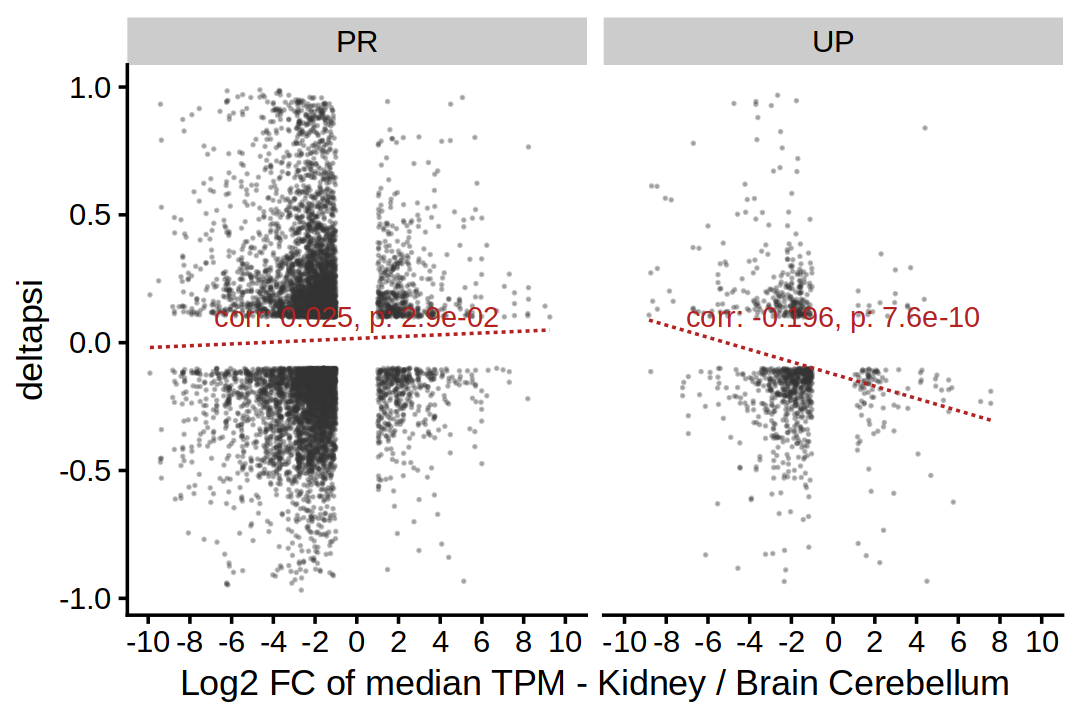

In [139]:
dt_scatter4 %>% 
    ggplot() + geom_point(aes(l2fc, deltapsi), alpha = .3, color = 'grey20', size = .1) +
        geom_smooth(aes(l2fc, deltapsi), method = "lm", formula = 'y~x', se = F, linetype = 'dashed', size =.5, color = 'firebrick') +
        geom_text(aes(x = 0, y = .1, label = label), data = cortest4.df, color = 'firebrick', size = 4) + 
        scale_x_continuous(limits = c(-10, 10), breaks = seq(-10,10,2)) +
        labs(x = 'Log2 FC of median TPM - Kidney / Brain Cerebellum') +
        facet_wrap(~itype, nrow=1)

In [140]:
names(introns)

[1] "Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes"
[2] "Brain-Cerebellum_v_Kidney-Cortex"                   
[3] "Brain-Cerebellum_v_Liver"                           
[4] "Liver_v_Kidney-Cortex"                              
[5] "Liver_v_Muscle-Skeletal"                            
[6] "Brain-Cortex_v_Brain-FrontalCortex_BA9_"            
[7] "WholeBlood_v_Muscle-Skeletal"

## DS up deltapsi in Liver_v_Kidney-Cortex

Note, the DS contrast is Kidney / Liver actually!

In [141]:
# gather data

dt_scatter5 <- plot_introns[grp == 'Liver_v_Kidney-Cortex']

In [142]:
# BC vs. LCL on median tpm (L2FC)

l2fc5 <- inner_join(x = tpm[['Liver']],
           y = tpm[['Kidney-Cortex']],
           by = c("Name", "Description"),
           suffix = c("_L", "_KC")
          ) %>% 
.[, .(Name, Description, medTPM_L, medTPM_KC, l2fc = log2(medTPM_L/medTPM_KC))] %>% 
.[!is.na(l2fc) & abs(l2fc) != Inf]

In [143]:
dt_scatter5[1:2]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr1:clu_1018_+,chr1:77916133:77917959:clu_1018_+,-0.1254840,PR,PR,3,AS-PR,Liver_v_Kidney-Cortex,NEXN,ENSG00000162614.19
chr1:clu_1025_+,chr1:78493541:78536405:clu_1025_+,-0.2074617,PR,"PR,UP",1,AS-NMD,Liver_v_Kidney-Cortex,PTGFR,ENSG00000122420.10


In [144]:
l2fc5[1:2]

Name,Description,medTPM_L,medTPM_KC,l2fc
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ENSG00000227232.5,WASH7P,1.76550,2.7710,-0.6503299
ENSG00000268020.3,OR4G4P,0.03327,0.0389,-0.2255483


In [145]:
dt_scatter5 <- left_join(x = dt_scatter5, 
                         y = l2fc5[, .(gene_name = Description, l2fc)],
                         by = 'gene_name') %>% 
    .[!is.na(l2fc) & abs(l2fc) > 1 & abs(l2fc) != Inf]

In [146]:
dt_scatter5[1:5]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id,l2fc
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
chr1:clu_1018_+,chr1:77916133:77917959:clu_1018_+,-0.1254840,PR,PR,3,AS-PR,Liver_v_Kidney-Cortex,NEXN,ENSG00000162614.19,-1.119591
chr1:clu_1025_+,chr1:78493541:78536405:clu_1025_+,-0.2074617,PR,"PR,UP",1,AS-NMD,Liver_v_Kidney-Cortex,PTGFR,ENSG00000122420.10,-1.341727
chr1:clu_1025_+,chr1:78532353:78536405:clu_1025_+,0.2074617,UP,"PR,UP",1,AS-NMD,Liver_v_Kidney-Cortex,PTGFR,ENSG00000122420.10,-1.341727
chr1:clu_103_+,chr1:4774558:4777400:clu_103_+,-0.1173203,PR,PR,2,AS-PR,Liver_v_Kidney-Cortex,AJAP1,ENSG00000196581.11,-4.630337
chr1:clu_103_+,chr1:4774558:4782544:clu_103_+,0.1173203,PR,PR,2,AS-PR,Liver_v_Kidney-Cortex,AJAP1,ENSG00000196581.11,-4.630337


In [147]:
dt_scatter5 %>% dim

[1] 1712   11

In [148]:
cortest5 <- dt_scatter5[, .(deltapsi, l2fc, itype)] %>% 
    split(by = c("itype")) %>% 
    map(~.x %$% cor.test(l2fc, deltapsi, method = 'p'))

In [149]:
cortest5.df <- data.table(itype = names(cortest5),
           pval = map_dbl(cortest5, ~.x[['p.value']]),
           cor = map_dbl(cortest5, ~.x[['estimate']])
          ) %>% 
    add_column(label = glue::glue("corr: {scales::number(.$cor, .001)}, p: {scales::scientific(.$pval, 2)}"))

In [150]:
cortest5 %>% print
cortest5.df

$PR

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = 0.83804, df = 1533, p-value = 0.4021
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.02866458  0.07135557
sample estimates:
       cor 
0.02139904 


$UP

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = -2.0292, df = 175, p-value = 0.04396
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.292574908 -0.004210909
sample estimates:
       cor 
-0.1516173 




itype,pval,cor,label
<chr>,<dbl>,<dbl>,<glue>
PR,0.40213885,0.02139904,"corr: 0.021, p: 4.0e-01"
UP,0.04395632,-0.15161734,"corr: -0.152, p: 4.4e-02"


In [151]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 180)

Warning message:
“Removed 4 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


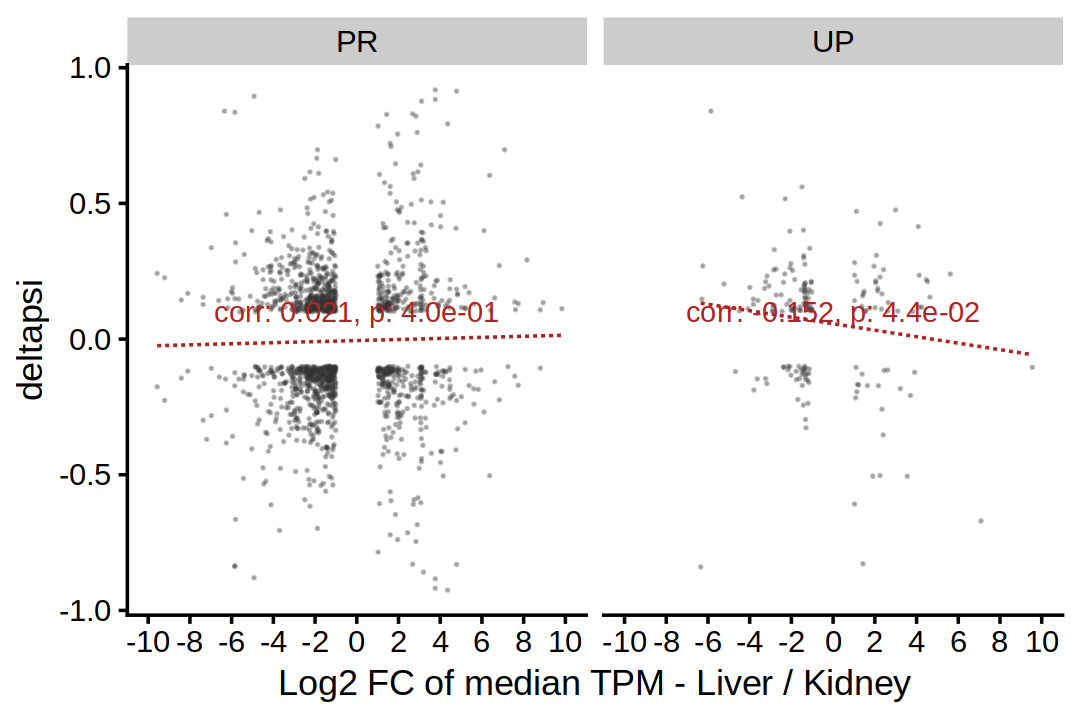

In [152]:
dt_scatter5 %>% 
    ggplot() + geom_point(aes(l2fc, deltapsi), alpha = .3, color = 'grey20', size = .1) +
        geom_smooth(aes(l2fc, deltapsi), method = "lm", formula = 'y~x', se = F, linetype = 'dashed', size =.5, color = 'firebrick') +
        geom_text(aes(x = 0, y = .1, label = label), data = cortest5.df, color = 'firebrick', size = 4) + 
        scale_x_continuous(limits = c(-10, 10), breaks = seq(-10,10,2)) +
        labs(x = 'Log2 FC of median TPM - Liver / Kidney') +
        facet_wrap(~itype, nrow=1)

## DS up deltapsi in WholeBlood_v_Muscle-Skeletal


In [153]:
# gather data

dt_scatter6 <- plot_introns[grp == 'WholeBlood_v_Muscle-Skeletal']

In [154]:
# BC vs. LCL on median tpm (L2FC)

l2fc6 <- inner_join(x = tpm[['WholeBlood']],
           y = tpm[['Muscle-Skeletal']],
           by = c("Name", "Description"),
           suffix = c("_WB", "_MS")
          ) %>% 
.[, .(Name, Description, medTPM_WB, medTPM_MS, l2fc = log2(medTPM_WB/medTPM_MS))] %>% 
.[!is.na(l2fc) & abs(l2fc) != Inf]

In [155]:
dt_scatter6[1:2]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr1:clu_1018_+,chr1:77916133:77917565:clu_1018_+,-0.3063232,PR,PR,3,AS-PR,WholeBlood_v_Muscle-Skeletal,NEXN,ENSG00000162614.19
chr1:clu_1018_+,chr1:77916133:77917959:clu_1018_+,0.6238768,PR,PR,3,AS-PR,WholeBlood_v_Muscle-Skeletal,NEXN,ENSG00000162614.19


In [156]:
l2fc6[1:2]

Name,Description,medTPM_WB,medTPM_MS,l2fc
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ENSG00000227232.5,WASH7P,2.64700,1.41700,0.9015184
ENSG00000238009.6,RP11-34P13.7,0.09644,0.01365,2.8207307


In [157]:
dt_scatter6 <- left_join(x = dt_scatter6, 
                         y = l2fc6[, .(gene_name = Description, l2fc)],
                         by = 'gene_name') %>% 
    .[!is.na(l2fc) & abs(l2fc) > 1 & abs(l2fc) != Inf]

Warning message in left_join(x = dt_scatter6, y = l2fc6[, .(gene_name = Description, :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 789 of `x` matches multiple rows in `y`.
ℹ Row 931 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [158]:
dt_scatter6[1:5]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id,l2fc
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
chr1:clu_1018_+,chr1:77916133:77917565:clu_1018_+,-0.3063232,PR,PR,3,AS-PR,WholeBlood_v_Muscle-Skeletal,NEXN,ENSG00000162614.19,-8.896625
chr1:clu_1018_+,chr1:77916133:77917959:clu_1018_+,0.6238768,PR,PR,3,AS-PR,WholeBlood_v_Muscle-Skeletal,NEXN,ENSG00000162614.19,-8.896625
chr1:clu_1018_+,chr1:77917757:77917959:clu_1018_+,-0.3175536,PR,PR,3,AS-PR,WholeBlood_v_Muscle-Skeletal,NEXN,ENSG00000162614.19,-8.896625
chr1:clu_1019_+,chr1:77918273:77925187:clu_1019_+,0.2001103,PR,PR,3,AS-PR,WholeBlood_v_Muscle-Skeletal,NEXN,ENSG00000162614.19,-8.896625
chr1:clu_1019_+,chr1:77918273:77926413:clu_1019_+,-0.3817834,PR,PR,3,AS-PR,WholeBlood_v_Muscle-Skeletal,NEXN,ENSG00000162614.19,-8.896625


In [159]:
dt_scatter6 %>% dim

[1] 6766   11

In [160]:
cortest6 <- dt_scatter6[, .(deltapsi, l2fc, itype)] %>% 
    split(by = c("itype")) %>% 
    map(~.x %$% cor.test(l2fc, deltapsi, method = 'p'))

In [161]:
cortest6.df <- data.table(itype = names(cortest6),
           pval = map_dbl(cortest6, ~.x[['p.value']]),
           cor = map_dbl(cortest6, ~.x[['estimate']])
          ) %>% 
    add_column(label = glue::glue("corr: {scales::number(.$cor, .001)}, p: {scales::scientific(.$pval, 2)}"))

In [162]:
cortest6 %>% print
cortest6.df

$PR

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = 1.4759, df = 6059, p-value = 0.14
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.006222342  0.044112147
sample estimates:
       cor 
0.01895691 


$UP

	Pearson's product-moment correlation

data:  l2fc and deltapsi
t = -3.7992, df = 703, p-value = 0.0001577
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.21344529 -0.06872169
sample estimates:
       cor 
-0.1418414 




itype,pval,cor,label
<chr>,<dbl>,<dbl>,<glue>
PR,0.1400325263,0.01895691,"corr: 0.019, p: 1.4e-01"
UP,0.0001577214,-0.14184137,"corr: -0.142, p: 1.6e-04"


In [163]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 180)

Warning message:
“Removed 53 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 53 rows containing missing values (`geom_point()`).”


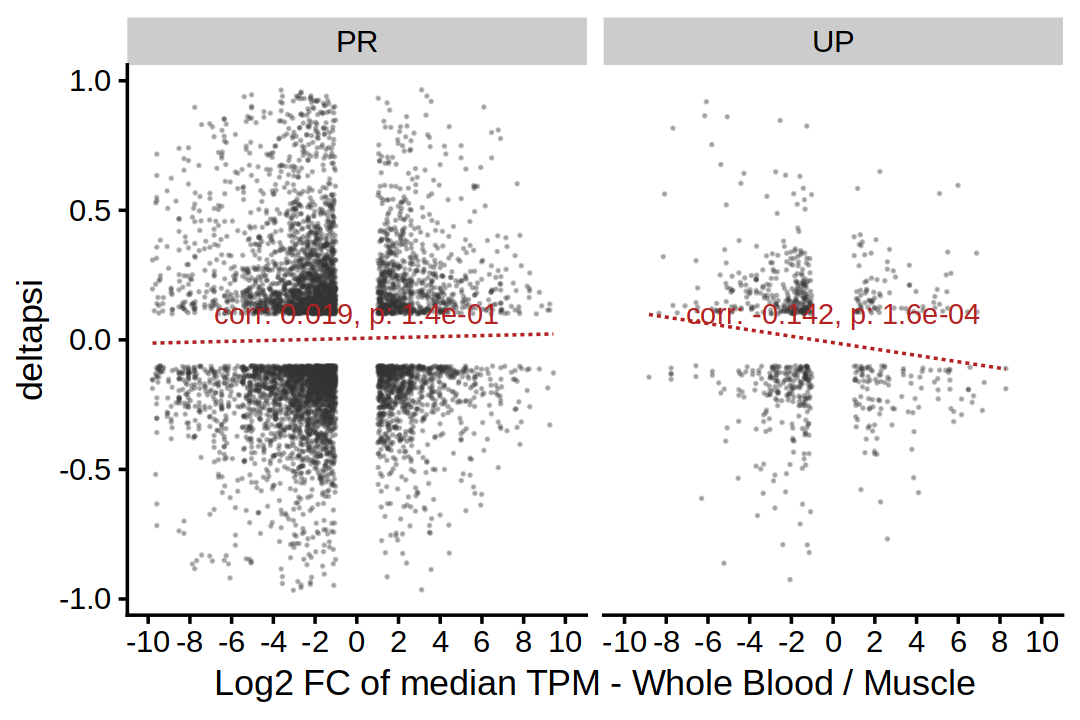

In [164]:
dt_scatter6 %>% 
    ggplot() + geom_point(aes(l2fc, deltapsi), alpha = .3, color = 'grey20', size = .1) +
        geom_smooth(aes(l2fc, deltapsi), method = "lm", formula = 'y~x', se = F, linetype = 'dashed', size =.5, color = 'firebrick') +
        geom_text(aes(x = 0, y = .1, label = label), data = cortest6.df, color = 'firebrick', size = 4) + 
        scale_x_continuous(limits = c(-10, 10), breaks = seq(-10,10,2)) +
        labs(x = 'Log2 FC of median TPM - Whole Blood / Muscle') +
        facet_wrap(~itype, nrow=1)

# Look for regions to plot sashimi

In [775]:
plot_introns[grp == 'Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes'] %>% 
    .[dstype == 'AS-NMD' & ]

cluster,intron,deltapsi,itype,ctype,nPR,dstype,grp,gene_name,gene_id
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr1:clu_1021_+,chr1:78080860:78092756:clu_1021_+,-0.9271973,UP,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,GIPC2,ENSG00000137960.6
chr1:clu_1021_+,chr1:78080860:78094951:clu_1021_+,0.9271973,PR,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,GIPC2,ENSG00000137960.6
chr1:clu_1118_+,chr1:96804939:96806418:clu_1118_+,-0.2954049,PR,"PR,UP",2,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,PTBP2,ENSG00000117569.20
chr1:clu_1118_+,chr1:96804939:96806865:clu_1118_+,0.7584031,UP,"PR,UP",2,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,PTBP2,ENSG00000117569.20
chr1:clu_1118_+,chr1:96806452:96806865:clu_1118_+,-0.4629982,PR,"PR,UP",2,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,PTBP2,ENSG00000117569.20
chr1:clu_1175_+,chr1:109200900:109202912:clu_1175_+,-0.2474657,UP,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ELAPOR1,ENSG00000116299.17
chr1:clu_1175_+,chr1:109200900:109202943:clu_1175_+,0.2474657,PR,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ELAPOR1,ENSG00000116299.17
chr1:clu_1179_+,chr1:109484080:109486056:clu_1179_+,0.4548809,PR,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ATXN7L2,ENSG00000162650.17
chr1:clu_1179_+,chr1:109485509:109486056:clu_1179_+,-0.3800595,UP,"PR,UP",1,AS-NMD,Brain-Cerebellum_v_Cells-EBV-transformedlymphocytes,ATXN7L2,ENSG00000162650.17


In [776]:
pryr::mem_used()

851 MB

In [777]:
ls()

[1] "betas"               "betas.f"             "betas.sig"          
 [4] "betas.sig2"          "brain1"              "cn"                 
 [7] "col2"                "comps"               "counts"             
[10] "counts.f"            "ds_clusters"         "ds_tbd"             
[13] "dt"                  "dt_scatter1"         "dt_scatter2"        
[16] "dt_scatter3"         "dt_scatter4"         "dt2"                
[19] "FDR"                 "genes"               "getIntronLabels"    
[22] "getMedianLFcounts"   "group1_cols"         "group2_cols"        
[25] "groups"              "header"              "hist1"              
[28] "hist2"               "hist2.2"             "hist3"              
[31] "introns"             "introns.f"           "labelClusterDStype" 
[34] "lcl1"                "liver1"              "med1"               
[37] "med2"                "muscle1"             "muslce1"            
[40] "newcols"             "olaps"               "plot_introns"       
[43] "plot_introns_to_bed" "pvals"               "pvals.f"            
[46] "relabelLong"         "sig.clusters"        "t1"                 
[49] "t2"                  "th_adpsi"            "tissues"            
[52] "tpm"                 "tpm.f"               "v1"                 
[55] "v2"                  "x"                   "xx"